# 1 初始化

## 1.1 导入包

In [1]:
import lightgbm as lgb
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from tqdm import tqdm
import logging

log_fmt = "[%(asctime)s] %(levelname)s in %(module)s: %(message)s"
logging.basicConfig(format=log_fmt, level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## 1.2 超参数定义

In [2]:
import gzip
import pickle
base_path = '/home/zengrui/datasets/190829_Kanshan_zjfx'

def save_param(param, param_name):
    with open(f'{base_path}/temp/{param_name}.txt', 'wb') as f:
        pickle.dump(param, f)
        
def read_param(param_name):
    with open(f'{base_path}/temp/{param_name}.txt', 'rb') as f:
        return pickle.load(f)

def gload(file_name):
    with gzip.GzipFile(f'{base_path}/temp/{file_name}.gzip', 'rb') as f:
        return pickle.load(f)

def gdump(obj, file_name):
    with gzip.GzipFile(f'{base_path}/temp/{file_name}.gzip', 'wb') as f:
        pickle.dump(obj, f)

## 1.3 函数定义

In [3]:
def extract_day(s):
    return s.apply(lambda x: int(x.split('-')[0][1:]))


def extract_hour(s):
    return s.apply(lambda x: int(x.split('-')[1][1:]))

# 2 加载、处理数据

## 2.1 加载邀请回答数据

In [5]:
train = pd.read_csv(f'{base_path}/invite_info_0926.txt', sep='\t', header=None)
train.columns = ['qid', 'uid', 'dt', 'label']
logging.info("invite %s", train.shape)

# test = pd.read_csv(f'{base_path}/invite_info_evaluate_1_0926.txt', sep='\t', header=None)
test = pd.read_csv(f'{base_path}/invite_info_evaluate_2_0926.txt', sep='\t', header=None)
test.columns = ['qid', 'uid', 'dt']
logging.info("test %s", test.shape)

sub = test.copy()

sub_size = len(sub)

train['day'] = extract_day(train['dt'])
train['hour'] = extract_hour(train['dt'])

test['day'] = extract_day(test['dt'])
test['hour'] = extract_hour(test['dt'])

del train['dt'], test['dt']

[2019-12-17 08:40:33,328] INFO in <ipython-input-5-9d8c57d6c194>: invite (9489162, 4)
[2019-12-17 08:40:34,295] INFO in <ipython-input-5-9d8c57d6c194>: test (1141718, 3)


## 2.2 加载问题

丢弃了**问题info**的字词编码。

In [6]:
ques = pd.read_csv(f'{base_path}/question_info_0926.txt', header=None, sep='\t')
ques.columns = ['qid', 'q_dt', 'title_t1', 'title_t2', 'desc_t1', 'desc_t2', 'topic']
del ques['title_t1'], ques['title_t2'], ques['desc_t1'], ques['desc_t2']
logging.info("ques %s", ques.shape)

ques['q_day'] = extract_day(ques['q_dt'])
ques['q_hour'] = extract_hour(ques['q_dt'])
del ques['q_dt']

[2019-12-17 08:41:45,890] INFO in <ipython-input-6-958902b92fc5>: ques (1829900, 3)


## 2.3 加载回答

丢弃了**回答info**的字词编码，并与**问题info**合并。

In [7]:
ans = pd.read_csv(f'{base_path}/answer_info_0926.txt', header=None, sep='\t')
ans.columns = ['aid', 'qid', 'uid', 'ans_dt', 'ans_t1', 'ans_t2', 'is_good', 'is_rec', 'is_dest', 'has_img',
               'has_video', 'word_count', 'reci_cheer', 'reci_uncheer', 'reci_comment', 'reci_mark', 'reci_tks',
               'reci_xxx', 'reci_no_help', 'reci_dis']
del ans['ans_t1'], ans['ans_t2']
logging.info("ans %s", ans.shape)

ans['a_day'] = extract_day(ans['ans_dt'])
ans['a_hour'] = extract_hour(ans['ans_dt'])
del ans['ans_dt']

ans = pd.merge(ans, ques, on='qid')
del ques

[2019-12-17 08:42:54,514] INFO in <ipython-input-7-935311f5f359>: ans (4513735, 18)


## 2.4 处理时间数据

回答距提问的天数。

In [8]:
ans['diff_qa_days'] = ans['a_day'] - ans['q_day']

时间窗口划分。

In [9]:
train_start = 3838
train_end = 3867

val_start = 3868
val_end = 3874

label_end = 3867
label_start = label_end - 6

train_label_feature_end = label_end - 7
train_label_feature_start = train_label_feature_end - 22

train_ans_feature_end = label_end - 7
train_ans_feature_start = train_ans_feature_end - 50

val_label_feature_end = val_start - 1
val_label_feature_start = val_label_feature_end - 22

val_ans_feature_end = val_start - 1
val_ans_feature_start = val_ans_feature_end - 50

train_label_feature = train[(train['day'] >= train_label_feature_start) & (train['day'] <= train_label_feature_end)]
logging.info("train_label_feature %s", train_label_feature.shape)

val_label_feature = train[(train['day'] >= val_label_feature_start) & (train['day'] <= val_label_feature_end)]
logging.info("val_label_feature %s", val_label_feature.shape)

train_label = train[(train['day'] > train_label_feature_end)]

logging.info("train feature start %s end %s, label start %s end %s", train_label_feature['day'].min(),
             train_label_feature['day'].max(), train_label['day'].min(), train_label['day'].max())

logging.info("test feature start %s end %s, label start %s end %s", val_label_feature['day'].min(),
             val_label_feature['day'].max(), test['day'].min(), test['day'].max())

[2019-12-17 08:43:17,284] INFO in <ipython-input-9-5c7aac178bca>: train_label_feature (6895493, 5)
[2019-12-17 08:43:17,818] INFO in <ipython-input-9-5c7aac178bca>: val_label_feature (7583553, 5)
[2019-12-17 08:43:18,047] INFO in <ipython-input-9-5c7aac178bca>: train feature start 3838 end 3860, label start 3861 end 3867
[2019-12-17 08:43:18,073] INFO in <ipython-input-9-5c7aac178bca>: test feature start 3845 end 3867, label start 3868 end 3874


```python
print(train_label_feature_start, train_label_feature_end)
print(train_ans_feature_start, train_ans_feature_end)
print(val_label_feature_start, val_label_feature_end)
print(val_ans_feature_start, val_ans_feature_end)
```
```text
3838 3860
3810 3860
3845 3867
3817 3867
```

确定ans的时间范围。

In [10]:
train_ans_feature = ans[(ans['a_day'] >= train_ans_feature_start) & (ans['a_day'] <= train_ans_feature_end)]

val_ans_feature = ans[(ans['a_day'] >= val_ans_feature_start) & (ans['a_day'] <= val_ans_feature_end)]

logging.info("train ans feature %s, start %s end %s", train_ans_feature.shape, train_ans_feature['a_day'].min(),
             train_ans_feature['a_day'].max())

logging.info("val ans feature %s, start %s end %s", val_ans_feature.shape, val_ans_feature['a_day'].min(),
             val_ans_feature['a_day'].max())

fea_cols = ['is_good', 'is_rec', 'is_dest', 'has_img', 'has_video', 'word_count',
            'reci_cheer', 'reci_uncheer', 'reci_comment', 'reci_mark', 'reci_tks',
            'reci_xxx', 'reci_no_help', 'reci_dis', 'diff_qa_days']

[2019-12-17 08:43:25,753] INFO in <ipython-input-10-502ad99fdbbb>: train ans feature (3700178, 23), start 3810 end 3860
[2019-12-17 08:43:25,763] INFO in <ipython-input-10-502ad99fdbbb>: val ans feature (3992334, 23), start 3817 end 3867


## 2.5 特征提取

In [11]:
def extract_feature1(target, label_feature, ans_feature):
    # 问题特征
    t1 = label_feature.groupby('qid')['label'].agg(['mean', 'sum', 'std', 'count', 
                                                    'max', 'min']).reset_index()
    t1.columns = ['qid', 'q_inv_mean', 'q_inv_sum', 'q_inv_std', 'q_inv_count', 
                  'q_inv_max', 'q_inv_min']
    target = pd.merge(target, t1, on='qid', how='left')

    # 用户特征
    t1 = label_feature.groupby('uid')['label'].agg(['mean', 'sum', 'std', 'count', 
                                                    'max', 'min']).reset_index()
    t1.columns = ['uid', 'u_inv_mean', 'u_inv_sum', 'u_inv_std', 'u_inv_count', 
                  'u_inv_max', 'u_inv_min']
    target = pd.merge(target, t1, on='uid', how='left')
    #
    # train_size = len(train)
    # data = pd.concat((train, test), sort=True)

    # 回答部分特征

    t1 = ans_feature.groupby('qid')['aid'].count().reset_index()
    t1.columns = ['qid', 'q_ans_count']
    target = pd.merge(target, t1, on='qid', how='left')

    t1 = ans_feature.groupby('uid')['aid'].count().reset_index()
    t1.columns = ['uid', 'u_ans_count']
    target = pd.merge(target, t1, on='uid', how='left')

    for col in fea_cols:
        t1 = ans_feature.groupby('uid')[col].agg(['sum', 'max', 'mean', 
                                                  'std', 'count', 'min']).reset_index()
        t1.columns = ['uid', f'u_{col}_sum', f'u_{col}_max', f'u_{col}_mean',
                      f'u_{col}_std', f'u_{col}_count', f'u_{col}_min']
        target = pd.merge(target, t1, on='uid', how='left')

        t1 = ans_feature.groupby('qid')[col].agg(['sum', 'max', 'mean',
                                                  'std', 'count', 'min']).reset_index()
        t1.columns = ['qid', f'q_{col}_sum', f'q_{col}_max', f'q_{col}_mean',
                      f'q_{col}_std', f'q_{col}_count', f'q_{col}_min']
        target = pd.merge(target, t1, on='qid', how='left')
        logging.info("extract %s", col)
    return target


train_label = extract_feature1(train_label, train_label_feature, train_ans_feature)
test = extract_feature1(test, val_label_feature, val_ans_feature)

[2019-12-17 08:44:12,676] INFO in <ipython-input-11-0304f9fa763e>: extract is_good
[2019-12-17 08:44:24,866] INFO in <ipython-input-11-0304f9fa763e>: extract is_rec
[2019-12-17 08:44:37,698] INFO in <ipython-input-11-0304f9fa763e>: extract is_dest
[2019-12-17 08:44:50,889] INFO in <ipython-input-11-0304f9fa763e>: extract has_img
[2019-12-17 08:45:04,695] INFO in <ipython-input-11-0304f9fa763e>: extract has_video
[2019-12-17 08:45:18,754] INFO in <ipython-input-11-0304f9fa763e>: extract word_count
[2019-12-17 08:45:32,900] INFO in <ipython-input-11-0304f9fa763e>: extract reci_cheer
[2019-12-17 08:45:49,871] INFO in <ipython-input-11-0304f9fa763e>: extract reci_uncheer
[2019-12-17 08:46:06,171] INFO in <ipython-input-11-0304f9fa763e>: extract reci_comment
[2019-12-17 08:46:22,343] INFO in <ipython-input-11-0304f9fa763e>: extract reci_mark
[2019-12-17 08:46:40,164] INFO in <ipython-input-11-0304f9fa763e>: extract reci_tks
[2019-12-17 08:46:59,242] INFO in <ipython-input-11-0304f9fa763e>: 

特征提取结束。

In [12]:
logging.info("train shape %s, test shape %s", train_label.shape, test.shape)
assert len(test) == sub_size

[2019-12-17 08:51:47,874] INFO in <ipython-input-12-6bad7a600272>: train shape (2593669, 199), test shape (1141718, 198)


## 2.6 加载用户

In [13]:
user = pd.read_csv(f'{base_path}/member_info_0926.txt', header=None, sep='\t')
user.columns = ['uid', 'gender', 'creat_keyword', 'level', 'hot', 'reg_type', 'reg_plat', 'freq', 'uf_b1', 'uf_b2',
                'uf_b3', 'uf_b4', 'uf_b5', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5', 'score', 'follow_topic',
                'inter_topic']
del user['follow_topic'], user['inter_topic']
logging.info("user %s", user.shape)

unq = user.nunique()
logging.info("user unq %s", unq)

for x in unq[unq == 1].index:
    del user[x]
    logging.info('del unq==1 %s', x)

t = user.dtypes
cats = [x for x in t[t == 'object'].index if x not in ['follow_topic', 'inter_topic', 'uid']]
logging.info("user cat %s", cats)

for d in cats:
    lb = LabelEncoder()
    user[d] = lb.fit_transform(user[d])
    logging.info('encode %s', d)

q_lb = LabelEncoder()
q_lb.fit(list(train_label['qid'].astype(str).values) + list(test['qid'].astype(str).values))
train_label['qid_enc'] = q_lb.transform(train_label['qid'])
test['qid_enc'] = q_lb.transform(test['qid'])

u_lb = LabelEncoder()
u_lb.fit(user['uid'])
train_label['uid_enc'] = u_lb.transform(train_label['uid'])
test['uid_enc'] = u_lb.transform(test['uid'])

[2019-12-17 08:52:10,521] INFO in <ipython-input-13-f4f8e8f0ac9b>: user (1931654, 19)
[2019-12-17 08:52:13,624] INFO in <ipython-input-13-f4f8e8f0ac9b>: user unq uid              1931654
gender                 3
creat_keyword          1
level                  1
hot                    1
reg_type               1
reg_plat               1
freq                   5
uf_b1                  2
uf_b2                  2
uf_b3                  2
uf_b4                  2
uf_b5                  2
uf_c1               2561
uf_c2                291
uf_c3                428
uf_c4               1556
uf_c5                  2
score                732
dtype: int64
[2019-12-17 08:52:13,657] INFO in <ipython-input-13-f4f8e8f0ac9b>: del unq==1 creat_keyword
[2019-12-17 08:52:13,662] INFO in <ipython-input-13-f4f8e8f0ac9b>: del unq==1 level
[2019-12-17 08:52:13,664] INFO in <ipython-input-13-f4f8e8f0ac9b>: del unq==1 hot
[2019-12-17 08:52:13,861] INFO in <ipython-input-13-f4f8e8f0ac9b>: del unq==1 reg_type
[2019

merge user

In [14]:
train_label = pd.merge(train_label, user, on='uid', how='left')
test = pd.merge(test, user, on='uid', how='left')
logging.info("train shape %s, test shape %s", train_label.shape, test.shape)

[2019-12-17 08:53:03,389] INFO in <ipython-input-14-a0af6fdcbd8e>: train shape (2593669, 214), test shape (1141718, 213)


及时清理内存。

In [15]:
del ans, train_label_feature, train_ans_feature, val_label_feature, val_ans_feature, user

In [16]:
data = pd.concat((train_label, test), axis=0, sort=True)
len_train_label = len(train_label)

# 暂存清理变量
save_param(train_label, 'train_label')
del train_label
del test

count编码。

In [17]:
data

,day,freq,gender,hour,label,q_ans_count,q_diff_qa_days_count,q_diff_qa_days_max,q_diff_qa_days_mean,q_diff_qa_days_min,...,uf_b3,uf_b4,uf_b5,uf_c1,uf_c2,uf_c3,uf_c4,uf_c5,uid,uid_enc
0,3865,4,2,22,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,2113,190,261,927,1,M401693808,1508098
1,3862,4,2,15,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1519,229,0,506,1,M2317670257,657985
2,3867,1,2,4,0.0,32.0,32.0,13.0,9.531250,0.0,...,0,0,0,551,226,188,815,1,M3544409350,1272353
3,3861,0,1,20,0.0,3.0,3.0,234.0,222.333333,215.0,...,0,0,0,1519,229,0,506,1,M2818659842,909154
4,3862,4,0,8,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,2161,31,396,1438,1,M848334644,1856019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141713,3872,0,2,13,NaN,22.0,22.0,14.0,10.181818,2.0,...,0,1,0,1511,190,119,758,1,M2490844425,744702
1141714,3873,0,0,13,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1190,130,396,1438,0,M1271605368,135419
1141715,3872,4,2,9,NaN,6.0,6.0,3.0,2.000000,1.0,...,0,0,0,1190,130,202,444,1,M1452284822,225598
1141716,3870,1,2,22,NaN,3.0,3.0,3.0,2.666667,2.0,...,0,0,0,1096,232,334,99,1,M521953190,1693080


In [18]:
count_fea = ['uid_enc', 'qid_enc', 'gender', 'freq', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5']
with tqdm(total=len(count_fea)) as pbar:
    for feat in count_fea:
        col_name = '{}_count'.format(feat)
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data.loc[data[col_name] < 2, feat] = -1
        data[feat] += 1
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data[col_name] = (data[col_name] - data[col_name].min()) / (data[col_name].max() - data[col_name].min())
        pbar.update(1)

100%|██████████| 9/9 [01:24<00:00,  9.44s/it]


## 2.7 处理数据

压缩数据。

In [19]:
t = data.dtypes
for x in t[t == 'int64'].index:
    data[x] = data[x].astype('int32')

for x in t[t == 'float64'].index:
    data[x] = data[x].astype('float32')

data['wk'] = data['day'] % 7

feature_cols = [x for x in data.columns if x not in ('label', 'uid', 'qid', 'dt', 'day')]

target编码。

In [20]:
logging.info("feature size %s", len(feature_cols))

# 恢复数据
train_label = read_param('train_label')
    
X_train_all = data.iloc[:len_train_label][feature_cols]
y_train_all = data.iloc[:len_train_label]['label']

test = data.iloc[len_train_label:]
# with open(f'{base_path}/temp/test.txt', 'wb') as f:
#     pickle.dump(test, f)
#     del test
    
assert len(data) - len_train_label == sub_size

[2019-12-17 09:02:08,964] INFO in <ipython-input-20-5a54c180d6dd>: feature size 220


# 3 训练树

## 3.1 预处理数据

In [23]:
logging.info("train shape %s, test shape %s", 
             data.iloc[:len_train_label].shape, 
             data.iloc[len_train_label:].shape)

save_param(data, 'data')
del data


# 分层采样，交叉验证（切分5片）
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 但只用了其中一次切片
for index, (train_idx, val_idx) in enumerate(fold.split(X=X_train_all, y=y_train_all)):
    break

X_train, X_val, y_train, y_val = X_train_all.iloc[train_idx][feature_cols], X_train_all.iloc[val_idx][feature_cols], \
                                 y_train_all.iloc[train_idx], \
                                 y_train_all.iloc[val_idx]
# del X_train_all

[2019-12-17 09:08:48,589] INFO in <ipython-input-23-9e41c446c44b>: train shape (2593669, 224), test shape (1141718, 224)


## 3.2 存取数据

存变量

In [24]:
save_param(X_train, 'X_train')
save_param(y_train, 'y_train')
save_param(X_val, 'X_val')
save_param(y_val, 'y_val')
save_param(test, 'test')
save_param(sub, 'sub')
save_param(X_train_all, 'X_train_all')
save_param(y_train_all, 'y_train_all')
save_param(feature_cols, 'feature_cols')

取变量

In [3]:
# X_train = read_param('X_train')
# y_train = read_param('y_train')
X_val = read_param('X_val')
y_val = read_param('y_val')
# test = read_param('test')
# sub = read_param('sub')
X_train_all = read_param('X_train_all')
y_train_all = gload('y_train_all')
# feature_cols = read_param('feature_cols')

## 3.3 LGBM分类器训练

### 3.3.1 LGBMClassifier

On ('dart', lr=0.5, n_estimators=200)
* Epoch 1: TPE using 33/33 trials with best loss 0.162092
* Epoch 2: TPE using 10/10 trials with best loss 0.162055
* Epoch 3: TPE using 8/8 trials with best loss 0.162175
* Epoch 4: TPE using 23/23 trials with best loss 0.161951
* Epoch 5: TPE using 15/15 trials with best loss 0.161962
* Epoch 6: TPE using 45/45 trials with best loss 0.161878

|param_name|epoch 1|epoch 2|epoch 3|epoch 4|epoch 5|final|
|:--|:--|:--|:--|:--|:--|:--|
|max_depth|20|24|22|20|20|20|
|num_leaves|200|200|180|180|190|190|
|min_child_samples|220|160|220|210|210|210|
|min_child_weight|0.056|0.045|0.045|0.055|0.055|0.055|
|feature_fraction|0.7|0.7|0.65|0.6|0.6|0.7|
|reg_alpha|0.001|0.029|0.001|0.009|0.005|0.005|
|reg_lambda|13.5|15.5|15|16|18|21|

In [6]:
model_lgb = LGBMClassifier(boosting_type='dart',
                           objective='binary', 
                           learning_rate=0.005,
                           n_estimators=10000, 
                           max_depth=20,
                           num_leaves=190,
                           min_child_samples=210,
                           min_child_weight=0.055,
                           feature_fraction=0.7,
                           reg_alpha=0.005,
                           reg_lambda=21,
                           n_jobs=16,
#                            seed=666, 
                           silent=True,
                           device='gpu',)
model_lgb.fit(X_train_all, y_train_all,
              eval_metric=['logloss', 'auc'],
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=50)

[1]	valid_0's auc: 0.787704	valid_0's binary_logloss: 0.438868
[2]	valid_0's auc: 0.79909	valid_0's binary_logloss: 0.438019
[3]	valid_0's auc: 0.799961	valid_0's binary_logloss: 0.437371
[4]	valid_0's auc: 0.803661	valid_0's binary_logloss: 0.436557
[5]	valid_0's auc: 0.806345	valid_0's binary_logloss: 0.435976
[6]	valid_0's auc: 0.808438	valid_0's binary_logloss: 0.435875
[7]	valid_0's auc: 0.809585	valid_0's binary_logloss: 0.43503
[8]	valid_0's auc: 0.809034	valid_0's binary_logloss: 0.434459
[9]	valid_0's auc: 0.809343	valid_0's binary_logloss: 0.434513
[10]	valid_0's auc: 0.809501	valid_0's binary_logloss: 0.434262
[11]	valid_0's auc: 0.809726	valid_0's binary_logloss: 0.433481
[12]	valid_0's auc: 0.810968	valid_0's binary_logloss: 0.432876
[13]	valid_0's auc: 0.81099	valid_0's binary_logloss: 0.432888
[14]	valid_0's auc: 0.811472	valid_0's binary_logloss: 0.432103
[15]	valid_0's auc: 0.811664	valid_0's binary_logloss: 0.431584
[16]	valid_0's auc: 0.811793	valid_0's binary_loglos

[130]	valid_0's auc: 0.814699	valid_0's binary_logloss: 0.444894
[131]	valid_0's auc: 0.81471	valid_0's binary_logloss: 0.445286
[132]	valid_0's auc: 0.814783	valid_0's binary_logloss: 0.444688
[133]	valid_0's auc: 0.814864	valid_0's binary_logloss: 0.444007
[134]	valid_0's auc: 0.814857	valid_0's binary_logloss: 0.443382
[135]	valid_0's auc: 0.81486	valid_0's binary_logloss: 0.443754
[136]	valid_0's auc: 0.814821	valid_0's binary_logloss: 0.443145
[137]	valid_0's auc: 0.814819	valid_0's binary_logloss: 0.45811
[138]	valid_0's auc: 0.814875	valid_0's binary_logloss: 0.457329
[139]	valid_0's auc: 0.814885	valid_0's binary_logloss: 0.457613
[140]	valid_0's auc: 0.814893	valid_0's binary_logloss: 0.457995
[141]	valid_0's auc: 0.814932	valid_0's binary_logloss: 0.457348
[142]	valid_0's auc: 0.815053	valid_0's binary_logloss: 0.456598
[143]	valid_0's auc: 0.815045	valid_0's binary_logloss: 0.456985
[144]	valid_0's auc: 0.81503	valid_0's binary_logloss: 0.456345
[145]	valid_0's auc: 0.815024

[257]	valid_0's auc: 0.815853	valid_0's binary_logloss: 0.449413
[258]	valid_0's auc: 0.815854	valid_0's binary_logloss: 0.449742
[259]	valid_0's auc: 0.815871	valid_0's binary_logloss: 0.449141
[260]	valid_0's auc: 0.81591	valid_0's binary_logloss: 0.448431
[261]	valid_0's auc: 0.815915	valid_0's binary_logloss: 0.448806
[262]	valid_0's auc: 0.815918	valid_0's binary_logloss: 0.448103
[263]	valid_0's auc: 0.815922	valid_0's binary_logloss: 0.448482
[264]	valid_0's auc: 0.815926	valid_0's binary_logloss: 0.448785
[265]	valid_0's auc: 0.815939	valid_0's binary_logloss: 0.448068
[266]	valid_0's auc: 0.815933	valid_0's binary_logloss: 0.448432
[267]	valid_0's auc: 0.815887	valid_0's binary_logloss: 0.447768
[268]	valid_0's auc: 0.815882	valid_0's binary_logloss: 0.448163
[269]	valid_0's auc: 0.815872	valid_0's binary_logloss: 0.448533
[270]	valid_0's auc: 0.815862	valid_0's binary_logloss: 0.448839
[271]	valid_0's auc: 0.815878	valid_0's binary_logloss: 0.448139
[272]	valid_0's auc: 0.815

[384]	valid_0's auc: 0.816908	valid_0's binary_logloss: 0.445927
[385]	valid_0's auc: 0.816909	valid_0's binary_logloss: 0.447919
[386]	valid_0's auc: 0.816925	valid_0's binary_logloss: 0.447202
[387]	valid_0's auc: 0.816939	valid_0's binary_logloss: 0.44656
[388]	valid_0's auc: 0.816982	valid_0's binary_logloss: 0.445915
[389]	valid_0's auc: 0.816982	valid_0's binary_logloss: 0.446271
[390]	valid_0's auc: 0.816973	valid_0's binary_logloss: 0.446657
[391]	valid_0's auc: 0.817014	valid_0's binary_logloss: 0.445943
[392]	valid_0's auc: 0.81703	valid_0's binary_logloss: 0.445282
[393]	valid_0's auc: 0.817068	valid_0's binary_logloss: 0.444647
[394]	valid_0's auc: 0.817068	valid_0's binary_logloss: 0.44499
[395]	valid_0's auc: 0.817061	valid_0's binary_logloss: 0.445334
[396]	valid_0's auc: 0.817109	valid_0's binary_logloss: 0.444685
[397]	valid_0's auc: 0.8171	valid_0's binary_logloss: 0.444089
[398]	valid_0's auc: 0.817096	valid_0's binary_logloss: 0.444453
[399]	valid_0's auc: 0.817048	

[511]	valid_0's auc: 0.817573	valid_0's binary_logloss: 0.431422
[512]	valid_0's auc: 0.817569	valid_0's binary_logloss: 0.431745
[513]	valid_0's auc: 0.81755	valid_0's binary_logloss: 0.431174
[514]	valid_0's auc: 0.817527	valid_0's binary_logloss: 0.430611
[515]	valid_0's auc: 0.817528	valid_0's binary_logloss: 0.430951
[516]	valid_0's auc: 0.817566	valid_0's binary_logloss: 0.430392
[517]	valid_0's auc: 0.817566	valid_0's binary_logloss: 0.430724
[518]	valid_0's auc: 0.817629	valid_0's binary_logloss: 0.430194
[519]	valid_0's auc: 0.817614	valid_0's binary_logloss: 0.429638
[520]	valid_0's auc: 0.817666	valid_0's binary_logloss: 0.429044
[521]	valid_0's auc: 0.817738	valid_0's binary_logloss: 0.428463
[522]	valid_0's auc: 0.817735	valid_0's binary_logloss: 0.428783
[523]	valid_0's auc: 0.817747	valid_0's binary_logloss: 0.428207
[524]	valid_0's auc: 0.817736	valid_0's binary_logloss: 0.427679
[525]	valid_0's auc: 0.817764	valid_0's binary_logloss: 0.427102
[526]	valid_0's auc: 0.817

[638]	valid_0's auc: 0.818711	valid_0's binary_logloss: 0.420029
[639]	valid_0's auc: 0.818744	valid_0's binary_logloss: 0.419509
[640]	valid_0's auc: 0.818744	valid_0's binary_logloss: 0.419782
[641]	valid_0's auc: 0.818741	valid_0's binary_logloss: 0.420068
[642]	valid_0's auc: 0.818746	valid_0's binary_logloss: 0.419551
[643]	valid_0's auc: 0.818774	valid_0's binary_logloss: 0.419039
[644]	valid_0's auc: 0.818795	valid_0's binary_logloss: 0.418537
[645]	valid_0's auc: 0.818816	valid_0's binary_logloss: 0.418021
[646]	valid_0's auc: 0.818863	valid_0's binary_logloss: 0.417555
[647]	valid_0's auc: 0.818867	valid_0's binary_logloss: 0.417781
[648]	valid_0's auc: 0.818907	valid_0's binary_logloss: 0.417323
[649]	valid_0's auc: 0.818943	valid_0's binary_logloss: 0.416826
[650]	valid_0's auc: 0.818944	valid_0's binary_logloss: 0.417068
[651]	valid_0's auc: 0.818923	valid_0's binary_logloss: 0.41662
[652]	valid_0's auc: 0.818919	valid_0's binary_logloss: 0.416875
[653]	valid_0's auc: 0.818

[765]	valid_0's auc: 0.820034	valid_0's binary_logloss: 0.401863
[766]	valid_0's auc: 0.820036	valid_0's binary_logloss: 0.402087
[767]	valid_0's auc: 0.820027	valid_0's binary_logloss: 0.401711
[768]	valid_0's auc: 0.820031	valid_0's binary_logloss: 0.401376
[769]	valid_0's auc: 0.820067	valid_0's binary_logloss: 0.401019
[770]	valid_0's auc: 0.820106	valid_0's binary_logloss: 0.400659
[771]	valid_0's auc: 0.820108	valid_0's binary_logloss: 0.400827
[772]	valid_0's auc: 0.820119	valid_0's binary_logloss: 0.400431
[773]	valid_0's auc: 0.820165	valid_0's binary_logloss: 0.400085
[774]	valid_0's auc: 0.820162	valid_0's binary_logloss: 0.399739
[775]	valid_0's auc: 0.820164	valid_0's binary_logloss: 0.399943
[776]	valid_0's auc: 0.82021	valid_0's binary_logloss: 0.399577
[777]	valid_0's auc: 0.820211	valid_0's binary_logloss: 0.399775
[778]	valid_0's auc: 0.820254	valid_0's binary_logloss: 0.399438
[779]	valid_0's auc: 0.820256	valid_0's binary_logloss: 0.399605
[780]	valid_0's auc: 0.820

[892]	valid_0's auc: 0.821325	valid_0's binary_logloss: 0.393495
[893]	valid_0's auc: 0.821373	valid_0's binary_logloss: 0.393183
[894]	valid_0's auc: 0.821375	valid_0's binary_logloss: 0.393317
[895]	valid_0's auc: 0.821364	valid_0's binary_logloss: 0.392998
[896]	valid_0's auc: 0.821367	valid_0's binary_logloss: 0.393169
[897]	valid_0's auc: 0.821367	valid_0's binary_logloss: 0.393351
[898]	valid_0's auc: 0.821371	valid_0's binary_logloss: 0.394085
[899]	valid_0's auc: 0.821387	valid_0's binary_logloss: 0.393739
[900]	valid_0's auc: 0.821402	valid_0's binary_logloss: 0.393391
[901]	valid_0's auc: 0.821404	valid_0's binary_logloss: 0.393565
[902]	valid_0's auc: 0.821403	valid_0's binary_logloss: 0.393249
[903]	valid_0's auc: 0.821406	valid_0's binary_logloss: 0.393377
[904]	valid_0's auc: 0.821407	valid_0's binary_logloss: 0.393555
[905]	valid_0's auc: 0.821402	valid_0's binary_logloss: 0.393243
[906]	valid_0's auc: 0.821405	valid_0's binary_logloss: 0.393972
[907]	valid_0's auc: 0.82

[1019]	valid_0's auc: 0.822313	valid_0's binary_logloss: 0.389181
[1020]	valid_0's auc: 0.822315	valid_0's binary_logloss: 0.389321
[1021]	valid_0's auc: 0.822318	valid_0's binary_logloss: 0.389478
[1022]	valid_0's auc: 0.82232	valid_0's binary_logloss: 0.389611
[1023]	valid_0's auc: 0.822322	valid_0's binary_logloss: 0.389754
[1024]	valid_0's auc: 0.822326	valid_0's binary_logloss: 0.389425
[1025]	valid_0's auc: 0.822328	valid_0's binary_logloss: 0.389571
[1026]	valid_0's auc: 0.82233	valid_0's binary_logloss: 0.389741
[1027]	valid_0's auc: 0.822355	valid_0's binary_logloss: 0.389406
[1028]	valid_0's auc: 0.822383	valid_0's binary_logloss: 0.389108
[1029]	valid_0's auc: 0.822421	valid_0's binary_logloss: 0.388786
[1030]	valid_0's auc: 0.822423	valid_0's binary_logloss: 0.388922
[1031]	valid_0's auc: 0.822431	valid_0's binary_logloss: 0.388603
[1032]	valid_0's auc: 0.822434	valid_0's binary_logloss: 0.388754
[1033]	valid_0's auc: 0.822436	valid_0's binary_logloss: 0.388902
[1034]	valid

[1144]	valid_0's auc: 0.823231	valid_0's binary_logloss: 0.382492
[1145]	valid_0's auc: 0.823255	valid_0's binary_logloss: 0.382211
[1146]	valid_0's auc: 0.823274	valid_0's binary_logloss: 0.381932
[1147]	valid_0's auc: 0.823277	valid_0's binary_logloss: 0.382034
[1148]	valid_0's auc: 0.8233	valid_0's binary_logloss: 0.381752
[1149]	valid_0's auc: 0.823303	valid_0's binary_logloss: 0.38186
[1150]	valid_0's auc: 0.823304	valid_0's binary_logloss: 0.381986
[1151]	valid_0's auc: 0.823307	valid_0's binary_logloss: 0.382095
[1152]	valid_0's auc: 0.823327	valid_0's binary_logloss: 0.381816
[1153]	valid_0's auc: 0.82333	valid_0's binary_logloss: 0.381929
[1154]	valid_0's auc: 0.82334	valid_0's binary_logloss: 0.381652
[1155]	valid_0's auc: 0.823342	valid_0's binary_logloss: 0.381776
[1156]	valid_0's auc: 0.823351	valid_0's binary_logloss: 0.381497
[1157]	valid_0's auc: 0.823353	valid_0's binary_logloss: 0.381641
[1158]	valid_0's auc: 0.823369	valid_0's binary_logloss: 0.381384
[1159]	valid_0'

[1269]	valid_0's auc: 0.824195	valid_0's binary_logloss: 0.374649
[1270]	valid_0's auc: 0.824196	valid_0's binary_logloss: 0.374439
[1271]	valid_0's auc: 0.824199	valid_0's binary_logloss: 0.374529
[1272]	valid_0's auc: 0.824205	valid_0's binary_logloss: 0.374293
[1273]	valid_0's auc: 0.824207	valid_0's binary_logloss: 0.374394
[1274]	valid_0's auc: 0.824209	valid_0's binary_logloss: 0.374502
[1275]	valid_0's auc: 0.824225	valid_0's binary_logloss: 0.374264
[1276]	valid_0's auc: 0.824227	valid_0's binary_logloss: 0.374357
[1277]	valid_0's auc: 0.824233	valid_0's binary_logloss: 0.374122
[1278]	valid_0's auc: 0.824234	valid_0's binary_logloss: 0.374224
[1279]	valid_0's auc: 0.824236	valid_0's binary_logloss: 0.374341
[1280]	valid_0's auc: 0.824238	valid_0's binary_logloss: 0.374466
[1281]	valid_0's auc: 0.82424	valid_0's binary_logloss: 0.374235
[1282]	valid_0's auc: 0.824242	valid_0's binary_logloss: 0.374358
[1283]	valid_0's auc: 0.824245	valid_0's binary_logloss: 0.374448
[1284]	vali

[1394]	valid_0's auc: 0.824805	valid_0's binary_logloss: 0.37023
[1395]	valid_0's auc: 0.824805	valid_0's binary_logloss: 0.370037
[1396]	valid_0's auc: 0.824807	valid_0's binary_logloss: 0.370109
[1397]	valid_0's auc: 0.824813	valid_0's binary_logloss: 0.36991
[1398]	valid_0's auc: 0.824834	valid_0's binary_logloss: 0.369728
[1399]	valid_0's auc: 0.82485	valid_0's binary_logloss: 0.369541
[1400]	valid_0's auc: 0.824866	valid_0's binary_logloss: 0.369355
[1401]	valid_0's auc: 0.824882	valid_0's binary_logloss: 0.36917
[1402]	valid_0's auc: 0.824886	valid_0's binary_logloss: 0.369271
[1403]	valid_0's auc: 0.824901	valid_0's binary_logloss: 0.369066
[1404]	valid_0's auc: 0.824903	valid_0's binary_logloss: 0.369155
[1405]	valid_0's auc: 0.82492	valid_0's binary_logloss: 0.368952
[1406]	valid_0's auc: 0.824922	valid_0's binary_logloss: 0.369028
[1407]	valid_0's auc: 0.824925	valid_0's binary_logloss: 0.369115
[1408]	valid_0's auc: 0.824942	valid_0's binary_logloss: 0.368941
[1409]	valid_0'

[1519]	valid_0's auc: 0.825741	valid_0's binary_logloss: 0.363606
[1520]	valid_0's auc: 0.825743	valid_0's binary_logloss: 0.363676
[1521]	valid_0's auc: 0.825764	valid_0's binary_logloss: 0.363519
[1522]	valid_0's auc: 0.825766	valid_0's binary_logloss: 0.363583
[1523]	valid_0's auc: 0.825768	valid_0's binary_logloss: 0.36367
[1524]	valid_0's auc: 0.82577	valid_0's binary_logloss: 0.363771
[1525]	valid_0's auc: 0.825772	valid_0's binary_logloss: 0.36387
[1526]	valid_0's auc: 0.825781	valid_0's binary_logloss: 0.363728
[1527]	valid_0's auc: 0.825784	valid_0's binary_logloss: 0.363787
[1528]	valid_0's auc: 0.825785	valid_0's binary_logloss: 0.363876
[1529]	valid_0's auc: 0.825788	valid_0's binary_logloss: 0.363924
[1530]	valid_0's auc: 0.825789	valid_0's binary_logloss: 0.364013
[1531]	valid_0's auc: 0.825814	valid_0's binary_logloss: 0.363856
[1532]	valid_0's auc: 0.825817	valid_0's binary_logloss: 0.363924
[1533]	valid_0's auc: 0.825841	valid_0's binary_logloss: 0.363768
[1534]	valid_

[1644]	valid_0's auc: 0.826542	valid_0's binary_logloss: 0.361134
[1645]	valid_0's auc: 0.826544	valid_0's binary_logloss: 0.361217
[1646]	valid_0's auc: 0.826549	valid_0's binary_logloss: 0.361067
[1647]	valid_0's auc: 0.826558	valid_0's binary_logloss: 0.360908
[1648]	valid_0's auc: 0.82656	valid_0's binary_logloss: 0.360973
[1649]	valid_0's auc: 0.826583	valid_0's binary_logloss: 0.360816
[1650]	valid_0's auc: 0.82659	valid_0's binary_logloss: 0.360695
[1651]	valid_0's auc: 0.826607	valid_0's binary_logloss: 0.36056
[1652]	valid_0's auc: 0.826609	valid_0's binary_logloss: 0.360632
[1653]	valid_0's auc: 0.826627	valid_0's binary_logloss: 0.360484
[1654]	valid_0's auc: 0.826629	valid_0's binary_logloss: 0.360557
[1655]	valid_0's auc: 0.826631	valid_0's binary_logloss: 0.360612
[1656]	valid_0's auc: 0.826642	valid_0's binary_logloss: 0.360455
[1657]	valid_0's auc: 0.826654	valid_0's binary_logloss: 0.36033
[1658]	valid_0's auc: 0.826657	valid_0's binary_logloss: 0.360417
[1659]	valid_0

[1769]	valid_0's auc: 0.827317	valid_0's binary_logloss: 0.356799
[1770]	valid_0's auc: 0.827319	valid_0's binary_logloss: 0.35685
[1771]	valid_0's auc: 0.827328	valid_0's binary_logloss: 0.356723
[1772]	valid_0's auc: 0.82733	valid_0's binary_logloss: 0.356779
[1773]	valid_0's auc: 0.827332	valid_0's binary_logloss: 0.356833
[1774]	valid_0's auc: 0.827351	valid_0's binary_logloss: 0.356715
[1775]	valid_0's auc: 0.827353	valid_0's binary_logloss: 0.356766
[1776]	valid_0's auc: 0.827363	valid_0's binary_logloss: 0.356631
[1777]	valid_0's auc: 0.827365	valid_0's binary_logloss: 0.3567
[1778]	valid_0's auc: 0.827366	valid_0's binary_logloss: 0.356582
[1779]	valid_0's auc: 0.827382	valid_0's binary_logloss: 0.356463
[1780]	valid_0's auc: 0.827384	valid_0's binary_logloss: 0.356533
[1781]	valid_0's auc: 0.827386	valid_0's binary_logloss: 0.356425
[1782]	valid_0's auc: 0.827405	valid_0's binary_logloss: 0.356288
[1783]	valid_0's auc: 0.827407	valid_0's binary_logloss: 0.356356
[1784]	valid_0

[1894]	valid_0's auc: 0.82826	valid_0's binary_logloss: 0.351286
[1895]	valid_0's auc: 0.828279	valid_0's binary_logloss: 0.351201
[1896]	valid_0's auc: 0.828296	valid_0's binary_logloss: 0.351117
[1897]	valid_0's auc: 0.828298	valid_0's binary_logloss: 0.351152
[1898]	valid_0's auc: 0.828308	valid_0's binary_logloss: 0.351074
[1899]	valid_0's auc: 0.828317	valid_0's binary_logloss: 0.350974
[1900]	valid_0's auc: 0.828319	valid_0's binary_logloss: 0.351016
[1901]	valid_0's auc: 0.828321	valid_0's binary_logloss: 0.351065
[1902]	valid_0's auc: 0.828324	valid_0's binary_logloss: 0.351118
[1903]	valid_0's auc: 0.828333	valid_0's binary_logloss: 0.351021
[1904]	valid_0's auc: 0.828342	valid_0's binary_logloss: 0.350921
[1905]	valid_0's auc: 0.828354	valid_0's binary_logloss: 0.350824
[1906]	valid_0's auc: 0.828354	valid_0's binary_logloss: 0.350741
[1907]	valid_0's auc: 0.828357	valid_0's binary_logloss: 0.350796
[1908]	valid_0's auc: 0.828376	valid_0's binary_logloss: 0.350709
[1909]	vali

[2019]	valid_0's auc: 0.829087	valid_0's binary_logloss: 0.349172
[2020]	valid_0's auc: 0.829089	valid_0's binary_logloss: 0.349215
[2021]	valid_0's auc: 0.8291	valid_0's binary_logloss: 0.349124
[2022]	valid_0's auc: 0.829103	valid_0's binary_logloss: 0.349285
[2023]	valid_0's auc: 0.829108	valid_0's binary_logloss: 0.3492
[2024]	valid_0's auc: 0.829112	valid_0's binary_logloss: 0.349113
[2025]	valid_0's auc: 0.829119	valid_0's binary_logloss: 0.349022
[2026]	valid_0's auc: 0.829121	valid_0's binary_logloss: 0.349076
[2027]	valid_0's auc: 0.829134	valid_0's binary_logloss: 0.348998
[2028]	valid_0's auc: 0.829149	valid_0's binary_logloss: 0.348908
[2029]	valid_0's auc: 0.829155	valid_0's binary_logloss: 0.348832
[2030]	valid_0's auc: 0.829161	valid_0's binary_logloss: 0.348743
[2031]	valid_0's auc: 0.829164	valid_0's binary_logloss: 0.348787
[2032]	valid_0's auc: 0.829176	valid_0's binary_logloss: 0.34871
[2033]	valid_0's auc: 0.829178	valid_0's binary_logloss: 0.348747
[2034]	valid_0'

[2144]	valid_0's auc: 0.829888	valid_0's binary_logloss: 0.347209
[2145]	valid_0's auc: 0.829901	valid_0's binary_logloss: 0.347138
[2146]	valid_0's auc: 0.829903	valid_0's binary_logloss: 0.347181
[2147]	valid_0's auc: 0.829906	valid_0's binary_logloss: 0.347217
[2148]	valid_0's auc: 0.82991	valid_0's binary_logloss: 0.347142
[2149]	valid_0's auc: 0.829912	valid_0's binary_logloss: 0.347188
[2150]	valid_0's auc: 0.829915	valid_0's binary_logloss: 0.347234
[2151]	valid_0's auc: 0.829917	valid_0's binary_logloss: 0.347282
[2152]	valid_0's auc: 0.82992	valid_0's binary_logloss: 0.34732
[2153]	valid_0's auc: 0.829922	valid_0's binary_logloss: 0.347366
[2154]	valid_0's auc: 0.829925	valid_0's binary_logloss: 0.347398
[2155]	valid_0's auc: 0.829927	valid_0's binary_logloss: 0.347425
[2156]	valid_0's auc: 0.82993	valid_0's binary_logloss: 0.34747
[2157]	valid_0's auc: 0.829932	valid_0's binary_logloss: 0.347515
[2158]	valid_0's auc: 0.829949	valid_0's binary_logloss: 0.347431
[2159]	valid_0'

[2269]	valid_0's auc: 0.830549	valid_0's binary_logloss: 0.346063
[2270]	valid_0's auc: 0.830552	valid_0's binary_logloss: 0.346098
[2271]	valid_0's auc: 0.830558	valid_0's binary_logloss: 0.34602
[2272]	valid_0's auc: 0.83056	valid_0's binary_logloss: 0.346061
[2273]	valid_0's auc: 0.830563	valid_0's binary_logloss: 0.346099
[2274]	valid_0's auc: 0.830568	valid_0's binary_logloss: 0.346023
[2275]	valid_0's auc: 0.830571	valid_0's binary_logloss: 0.346063
[2276]	valid_0's auc: 0.830573	valid_0's binary_logloss: 0.346107
[2277]	valid_0's auc: 0.830575	valid_0's binary_logloss: 0.346149
[2278]	valid_0's auc: 0.830577	valid_0's binary_logloss: 0.346192
[2279]	valid_0's auc: 0.830585	valid_0's binary_logloss: 0.346113
[2280]	valid_0's auc: 0.830588	valid_0's binary_logloss: 0.346039
[2281]	valid_0's auc: 0.83059	valid_0's binary_logloss: 0.346082
[2282]	valid_0's auc: 0.830592	valid_0's binary_logloss: 0.346116
[2283]	valid_0's auc: 0.8306	valid_0's binary_logloss: 0.346037
[2284]	valid_0'

[2394]	valid_0's auc: 0.831096	valid_0's binary_logloss: 0.345084
[2395]	valid_0's auc: 0.831098	valid_0's binary_logloss: 0.345127
[2396]	valid_0's auc: 0.8311	valid_0's binary_logloss: 0.345155
[2397]	valid_0's auc: 0.831103	valid_0's binary_logloss: 0.345088
[2398]	valid_0's auc: 0.831105	valid_0's binary_logloss: 0.345111
[2399]	valid_0's auc: 0.831108	valid_0's binary_logloss: 0.345234
[2400]	valid_0's auc: 0.831111	valid_0's binary_logloss: 0.345167
[2401]	valid_0's auc: 0.831113	valid_0's binary_logloss: 0.345207
[2402]	valid_0's auc: 0.831117	valid_0's binary_logloss: 0.345134
[2403]	valid_0's auc: 0.831123	valid_0's binary_logloss: 0.345071
[2404]	valid_0's auc: 0.831135	valid_0's binary_logloss: 0.345006
[2405]	valid_0's auc: 0.831136	valid_0's binary_logloss: 0.345041
[2406]	valid_0's auc: 0.831141	valid_0's binary_logloss: 0.344975
[2407]	valid_0's auc: 0.83114	valid_0's binary_logloss: 0.344914
[2408]	valid_0's auc: 0.831143	valid_0's binary_logloss: 0.344845
[2409]	valid_

[2519]	valid_0's auc: 0.831658	valid_0's binary_logloss: 0.3431
[2520]	valid_0's auc: 0.83166	valid_0's binary_logloss: 0.343122
[2521]	valid_0's auc: 0.831665	valid_0's binary_logloss: 0.343063
[2522]	valid_0's auc: 0.831671	valid_0's binary_logloss: 0.343007
[2523]	valid_0's auc: 0.831673	valid_0's binary_logloss: 0.343044
[2524]	valid_0's auc: 0.831674	valid_0's binary_logloss: 0.343076
[2525]	valid_0's auc: 0.831688	valid_0's binary_logloss: 0.343019
[2526]	valid_0's auc: 0.831691	valid_0's binary_logloss: 0.343045
[2527]	valid_0's auc: 0.831693	valid_0's binary_logloss: 0.343075
[2528]	valid_0's auc: 0.831698	valid_0's binary_logloss: 0.343018
[2529]	valid_0's auc: 0.831711	valid_0's binary_logloss: 0.342967
[2530]	valid_0's auc: 0.831715	valid_0's binary_logloss: 0.342908
[2531]	valid_0's auc: 0.831717	valid_0's binary_logloss: 0.34293
[2532]	valid_0's auc: 0.831729	valid_0's binary_logloss: 0.342874
[2533]	valid_0's auc: 0.831737	valid_0's binary_logloss: 0.34282
[2534]	valid_0'

[2644]	valid_0's auc: 0.832218	valid_0's binary_logloss: 0.341928
[2645]	valid_0's auc: 0.83222	valid_0's binary_logloss: 0.34195
[2646]	valid_0's auc: 0.832231	valid_0's binary_logloss: 0.341888
[2647]	valid_0's auc: 0.832246	valid_0's binary_logloss: 0.341836
[2648]	valid_0's auc: 0.832255	valid_0's binary_logloss: 0.341785
[2649]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.341726
[2650]	valid_0's auc: 0.832271	valid_0's binary_logloss: 0.341676
[2651]	valid_0's auc: 0.832281	valid_0's binary_logloss: 0.341632
[2652]	valid_0's auc: 0.832295	valid_0's binary_logloss: 0.341581
[2653]	valid_0's auc: 0.832298	valid_0's binary_logloss: 0.341606
[2654]	valid_0's auc: 0.8323	valid_0's binary_logloss: 0.34163
[2655]	valid_0's auc: 0.832302	valid_0's binary_logloss: 0.341669
[2656]	valid_0's auc: 0.832313	valid_0's binary_logloss: 0.34162
[2657]	valid_0's auc: 0.832315	valid_0's binary_logloss: 0.341573
[2658]	valid_0's auc: 0.832318	valid_0's binary_logloss: 0.3416
[2659]	valid_0's a

[2769]	valid_0's auc: 0.832782	valid_0's binary_logloss: 0.340181
[2770]	valid_0's auc: 0.832784	valid_0's binary_logloss: 0.340205
[2771]	valid_0's auc: 0.832792	valid_0's binary_logloss: 0.340154
[2772]	valid_0's auc: 0.832795	valid_0's binary_logloss: 0.340185
[2773]	valid_0's auc: 0.832803	valid_0's binary_logloss: 0.340146
[2774]	valid_0's auc: 0.832805	valid_0's binary_logloss: 0.340167
[2775]	valid_0's auc: 0.832808	valid_0's binary_logloss: 0.340196
[2776]	valid_0's auc: 0.832809	valid_0's binary_logloss: 0.34022
[2777]	valid_0's auc: 0.832818	valid_0's binary_logloss: 0.340177
[2778]	valid_0's auc: 0.83282	valid_0's binary_logloss: 0.340206
[2779]	valid_0's auc: 0.83283	valid_0's binary_logloss: 0.340171
[2780]	valid_0's auc: 0.832835	valid_0's binary_logloss: 0.340122
[2781]	valid_0's auc: 0.832838	valid_0's binary_logloss: 0.340079
[2782]	valid_0's auc: 0.83284	valid_0's binary_logloss: 0.340096
[2783]	valid_0's auc: 0.832844	valid_0's binary_logloss: 0.340047
[2784]	valid_0

[2894]	valid_0's auc: 0.83336	valid_0's binary_logloss: 0.338794
[2895]	valid_0's auc: 0.833362	valid_0's binary_logloss: 0.338811
[2896]	valid_0's auc: 0.833372	valid_0's binary_logloss: 0.338768
[2897]	valid_0's auc: 0.833374	valid_0's binary_logloss: 0.338799
[2898]	valid_0's auc: 0.833384	valid_0's binary_logloss: 0.338768
[2899]	valid_0's auc: 0.833386	valid_0's binary_logloss: 0.338786
[2900]	valid_0's auc: 0.83339	valid_0's binary_logloss: 0.338743
[2901]	valid_0's auc: 0.833394	valid_0's binary_logloss: 0.338701
[2902]	valid_0's auc: 0.833399	valid_0's binary_logloss: 0.338663
[2903]	valid_0's auc: 0.833401	valid_0's binary_logloss: 0.338691
[2904]	valid_0's auc: 0.833403	valid_0's binary_logloss: 0.338717
[2905]	valid_0's auc: 0.833405	valid_0's binary_logloss: 0.338742
[2906]	valid_0's auc: 0.833407	valid_0's binary_logloss: 0.338702
[2907]	valid_0's auc: 0.833415	valid_0's binary_logloss: 0.338661
[2908]	valid_0's auc: 0.833424	valid_0's binary_logloss: 0.338617
[2909]	valid

[3019]	valid_0's auc: 0.833926	valid_0's binary_logloss: 0.337702
[3020]	valid_0's auc: 0.833929	valid_0's binary_logloss: 0.337725
[3021]	valid_0's auc: 0.833934	valid_0's binary_logloss: 0.337686
[3022]	valid_0's auc: 0.833942	valid_0's binary_logloss: 0.337656
[3023]	valid_0's auc: 0.833944	valid_0's binary_logloss: 0.33768
[3024]	valid_0's auc: 0.833956	valid_0's binary_logloss: 0.337646
[3025]	valid_0's auc: 0.833958	valid_0's binary_logloss: 0.337662
[3026]	valid_0's auc: 0.83396	valid_0's binary_logloss: 0.337684
[3027]	valid_0's auc: 0.83397	valid_0's binary_logloss: 0.337649
[3028]	valid_0's auc: 0.833977	valid_0's binary_logloss: 0.337621
[3029]	valid_0's auc: 0.83398	valid_0's binary_logloss: 0.337644
[3030]	valid_0's auc: 0.833988	valid_0's binary_logloss: 0.33761
[3031]	valid_0's auc: 0.833999	valid_0's binary_logloss: 0.337575
[3032]	valid_0's auc: 0.834001	valid_0's binary_logloss: 0.337594
[3033]	valid_0's auc: 0.834003	valid_0's binary_logloss: 0.337621
[3034]	valid_0'

[3144]	valid_0's auc: 0.834452	valid_0's binary_logloss: 0.336801
[3145]	valid_0's auc: 0.834453	valid_0's binary_logloss: 0.336813
[3146]	valid_0's auc: 0.834455	valid_0's binary_logloss: 0.336832
[3147]	valid_0's auc: 0.834458	valid_0's binary_logloss: 0.336856
[3148]	valid_0's auc: 0.83446	valid_0's binary_logloss: 0.336822
[3149]	valid_0's auc: 0.834462	valid_0's binary_logloss: 0.33679
[3150]	valid_0's auc: 0.834471	valid_0's binary_logloss: 0.336762
[3151]	valid_0's auc: 0.834479	valid_0's binary_logloss: 0.336734
[3152]	valid_0's auc: 0.834482	valid_0's binary_logloss: 0.3367
[3153]	valid_0's auc: 0.834484	valid_0's binary_logloss: 0.336712
[3154]	valid_0's auc: 0.834486	valid_0's binary_logloss: 0.336732
[3155]	valid_0's auc: 0.83449	valid_0's binary_logloss: 0.336703
[3156]	valid_0's auc: 0.834492	valid_0's binary_logloss: 0.336724
[3157]	valid_0's auc: 0.834496	valid_0's binary_logloss: 0.336692
[3158]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.336719
[3159]	valid_0'

[3269]	valid_0's auc: 0.834921	valid_0's binary_logloss: 0.336187
[3270]	valid_0's auc: 0.834923	valid_0's binary_logloss: 0.336204
[3271]	valid_0's auc: 0.834925	valid_0's binary_logloss: 0.336223
[3272]	valid_0's auc: 0.834927	valid_0's binary_logloss: 0.336282
[3273]	valid_0's auc: 0.834929	valid_0's binary_logloss: 0.336301
[3274]	valid_0's auc: 0.834931	valid_0's binary_logloss: 0.336315
[3275]	valid_0's auc: 0.834935	valid_0's binary_logloss: 0.336281
[3276]	valid_0's auc: 0.834938	valid_0's binary_logloss: 0.336248
[3277]	valid_0's auc: 0.834941	valid_0's binary_logloss: 0.336265
[3278]	valid_0's auc: 0.834948	valid_0's binary_logloss: 0.336235
[3279]	valid_0's auc: 0.834951	valid_0's binary_logloss: 0.336255
[3280]	valid_0's auc: 0.83496	valid_0's binary_logloss: 0.336227
[3281]	valid_0's auc: 0.834962	valid_0's binary_logloss: 0.336241
[3282]	valid_0's auc: 0.834967	valid_0's binary_logloss: 0.336209
[3283]	valid_0's auc: 0.834969	valid_0's binary_logloss: 0.336228
[3284]	vali

[3394]	valid_0's auc: 0.835333	valid_0's binary_logloss: 0.335702
[3395]	valid_0's auc: 0.835335	valid_0's binary_logloss: 0.335721
[3396]	valid_0's auc: 0.835337	valid_0's binary_logloss: 0.335736
[3397]	valid_0's auc: 0.835339	valid_0's binary_logloss: 0.335753
[3398]	valid_0's auc: 0.835341	valid_0's binary_logloss: 0.335769
[3399]	valid_0's auc: 0.835345	valid_0's binary_logloss: 0.335737
[3400]	valid_0's auc: 0.835346	valid_0's binary_logloss: 0.335752
[3401]	valid_0's auc: 0.835351	valid_0's binary_logloss: 0.335719
[3402]	valid_0's auc: 0.835354	valid_0's binary_logloss: 0.335687
[3403]	valid_0's auc: 0.835355	valid_0's binary_logloss: 0.3357
[3404]	valid_0's auc: 0.835358	valid_0's binary_logloss: 0.335716
[3405]	valid_0's auc: 0.83536	valid_0's binary_logloss: 0.335737
[3406]	valid_0's auc: 0.835361	valid_0's binary_logloss: 0.335706
[3407]	valid_0's auc: 0.835364	valid_0's binary_logloss: 0.335727
[3408]	valid_0's auc: 0.835366	valid_0's binary_logloss: 0.335741
[3409]	valid_

[3519]	valid_0's auc: 0.835744	valid_0's binary_logloss: 0.334899
[3520]	valid_0's auc: 0.835746	valid_0's binary_logloss: 0.334873
[3521]	valid_0's auc: 0.83575	valid_0's binary_logloss: 0.33485
[3522]	valid_0's auc: 0.835756	valid_0's binary_logloss: 0.334821
[3523]	valid_0's auc: 0.835757	valid_0's binary_logloss: 0.334839
[3524]	valid_0's auc: 0.835761	valid_0's binary_logloss: 0.334813
[3525]	valid_0's auc: 0.835769	valid_0's binary_logloss: 0.334791
[3526]	valid_0's auc: 0.835771	valid_0's binary_logloss: 0.334763
[3527]	valid_0's auc: 0.835775	valid_0's binary_logloss: 0.334737
[3528]	valid_0's auc: 0.835777	valid_0's binary_logloss: 0.334752
[3529]	valid_0's auc: 0.835782	valid_0's binary_logloss: 0.334727
[3530]	valid_0's auc: 0.835784	valid_0's binary_logloss: 0.33474
[3531]	valid_0's auc: 0.835791	valid_0's binary_logloss: 0.334717
[3532]	valid_0's auc: 0.835793	valid_0's binary_logloss: 0.33473
[3533]	valid_0's auc: 0.835795	valid_0's binary_logloss: 0.334746
[3534]	valid_0

[3644]	valid_0's auc: 0.836158	valid_0's binary_logloss: 0.334178
[3645]	valid_0's auc: 0.83616	valid_0's binary_logloss: 0.334155
[3646]	valid_0's auc: 0.836166	valid_0's binary_logloss: 0.334127
[3647]	valid_0's auc: 0.836176	valid_0's binary_logloss: 0.334103
[3648]	valid_0's auc: 0.836181	valid_0's binary_logloss: 0.33408
[3649]	valid_0's auc: 0.836183	valid_0's binary_logloss: 0.33409
[3650]	valid_0's auc: 0.836185	valid_0's binary_logloss: 0.334103
[3651]	valid_0's auc: 0.836187	valid_0's binary_logloss: 0.334119
[3652]	valid_0's auc: 0.836189	valid_0's binary_logloss: 0.33414
[3653]	valid_0's auc: 0.836195	valid_0's binary_logloss: 0.334119
[3654]	valid_0's auc: 0.836197	valid_0's binary_logloss: 0.334169
[3655]	valid_0's auc: 0.836203	valid_0's binary_logloss: 0.334148
[3656]	valid_0's auc: 0.836205	valid_0's binary_logloss: 0.33416
[3657]	valid_0's auc: 0.836207	valid_0's binary_logloss: 0.334176
[3658]	valid_0's auc: 0.836209	valid_0's binary_logloss: 0.334189
[3659]	valid_0'

[3769]	valid_0's auc: 0.836559	valid_0's binary_logloss: 0.33367
[3770]	valid_0's auc: 0.836561	valid_0's binary_logloss: 0.333683
[3771]	valid_0's auc: 0.836562	valid_0's binary_logloss: 0.333691
[3772]	valid_0's auc: 0.836563	valid_0's binary_logloss: 0.333704
[3773]	valid_0's auc: 0.836565	valid_0's binary_logloss: 0.333713
[3774]	valid_0's auc: 0.836572	valid_0's binary_logloss: 0.33369
[3775]	valid_0's auc: 0.836574	valid_0's binary_logloss: 0.333703
[3776]	valid_0's auc: 0.836579	valid_0's binary_logloss: 0.333676
[3777]	valid_0's auc: 0.836581	valid_0's binary_logloss: 0.333689
[3778]	valid_0's auc: 0.836588	valid_0's binary_logloss: 0.333668
[3779]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.333681
[3780]	valid_0's auc: 0.836592	valid_0's binary_logloss: 0.333692
[3781]	valid_0's auc: 0.836597	valid_0's binary_logloss: 0.333668
[3782]	valid_0's auc: 0.836604	valid_0's binary_logloss: 0.333647
[3783]	valid_0's auc: 0.836605	valid_0's binary_logloss: 0.333624
[3784]	valid_

[3894]	valid_0's auc: 0.836957	valid_0's binary_logloss: 0.333195
[3895]	valid_0's auc: 0.836959	valid_0's binary_logloss: 0.333208
[3896]	valid_0's auc: 0.83696	valid_0's binary_logloss: 0.333216
[3897]	valid_0's auc: 0.836962	valid_0's binary_logloss: 0.333229
[3898]	valid_0's auc: 0.836964	valid_0's binary_logloss: 0.333209
[3899]	valid_0's auc: 0.836967	valid_0's binary_logloss: 0.333187
[3900]	valid_0's auc: 0.836971	valid_0's binary_logloss: 0.333163
[3901]	valid_0's auc: 0.836973	valid_0's binary_logloss: 0.333142
[3902]	valid_0's auc: 0.836977	valid_0's binary_logloss: 0.333119
[3903]	valid_0's auc: 0.836979	valid_0's binary_logloss: 0.333133
[3904]	valid_0's auc: 0.836981	valid_0's binary_logloss: 0.333111
[3905]	valid_0's auc: 0.836985	valid_0's binary_logloss: 0.333089
[3906]	valid_0's auc: 0.836987	valid_0's binary_logloss: 0.333103
[3907]	valid_0's auc: 0.836991	valid_0's binary_logloss: 0.333082
[3908]	valid_0's auc: 0.836993	valid_0's binary_logloss: 0.333091
[3909]	vali

[4019]	valid_0's auc: 0.837372	valid_0's binary_logloss: 0.332445
[4020]	valid_0's auc: 0.837374	valid_0's binary_logloss: 0.332425
[4021]	valid_0's auc: 0.837375	valid_0's binary_logloss: 0.332433
[4022]	valid_0's auc: 0.837378	valid_0's binary_logloss: 0.332416
[4023]	valid_0's auc: 0.837382	valid_0's binary_logloss: 0.332395
[4024]	valid_0's auc: 0.837384	valid_0's binary_logloss: 0.332409
[4025]	valid_0's auc: 0.837386	valid_0's binary_logloss: 0.332419
[4026]	valid_0's auc: 0.837387	valid_0's binary_logloss: 0.33243
[4027]	valid_0's auc: 0.837389	valid_0's binary_logloss: 0.332443
[4028]	valid_0's auc: 0.837391	valid_0's binary_logloss: 0.332453
[4029]	valid_0's auc: 0.837393	valid_0's binary_logloss: 0.332464
[4030]	valid_0's auc: 0.837396	valid_0's binary_logloss: 0.332476
[4031]	valid_0's auc: 0.837404	valid_0's binary_logloss: 0.332455
[4032]	valid_0's auc: 0.83741	valid_0's binary_logloss: 0.332438
[4033]	valid_0's auc: 0.837413	valid_0's binary_logloss: 0.332451
[4034]	valid

[4144]	valid_0's auc: 0.837767	valid_0's binary_logloss: 0.331999
[4145]	valid_0's auc: 0.837769	valid_0's binary_logloss: 0.33201
[4146]	valid_0's auc: 0.837776	valid_0's binary_logloss: 0.331992
[4147]	valid_0's auc: 0.837778	valid_0's binary_logloss: 0.332006
[4148]	valid_0's auc: 0.83778	valid_0's binary_logloss: 0.332017
[4149]	valid_0's auc: 0.837782	valid_0's binary_logloss: 0.332026
[4150]	valid_0's auc: 0.837784	valid_0's binary_logloss: 0.332038
[4151]	valid_0's auc: 0.837786	valid_0's binary_logloss: 0.332018
[4152]	valid_0's auc: 0.837788	valid_0's binary_logloss: 0.332027
[4153]	valid_0's auc: 0.83779	valid_0's binary_logloss: 0.332039
[4154]	valid_0's auc: 0.837792	valid_0's binary_logloss: 0.332019
[4155]	valid_0's auc: 0.837795	valid_0's binary_logloss: 0.332032
[4156]	valid_0's auc: 0.8378	valid_0's binary_logloss: 0.332016
[4157]	valid_0's auc: 0.837802	valid_0's binary_logloss: 0.331997
[4158]	valid_0's auc: 0.837803	valid_0's binary_logloss: 0.332009
[4159]	valid_0'

[4269]	valid_0's auc: 0.838081	valid_0's binary_logloss: 0.331813
[4270]	valid_0's auc: 0.838087	valid_0's binary_logloss: 0.331796
[4271]	valid_0's auc: 0.838089	valid_0's binary_logloss: 0.331803
[4272]	valid_0's auc: 0.83809	valid_0's binary_logloss: 0.33181
[4273]	valid_0's auc: 0.838092	valid_0's binary_logloss: 0.331817
[4274]	valid_0's auc: 0.838094	valid_0's binary_logloss: 0.331832
[4275]	valid_0's auc: 0.838096	valid_0's binary_logloss: 0.331844
[4276]	valid_0's auc: 0.838098	valid_0's binary_logloss: 0.331858
[4277]	valid_0's auc: 0.838099	valid_0's binary_logloss: 0.331839
[4278]	valid_0's auc: 0.8381	valid_0's binary_logloss: 0.331822
[4279]	valid_0's auc: 0.838102	valid_0's binary_logloss: 0.331832
[4280]	valid_0's auc: 0.838105	valid_0's binary_logloss: 0.331844
[4281]	valid_0's auc: 0.838106	valid_0's binary_logloss: 0.331853
[4282]	valid_0's auc: 0.838115	valid_0's binary_logloss: 0.331836
[4283]	valid_0's auc: 0.838117	valid_0's binary_logloss: 0.331847
[4284]	valid_0

[4394]	valid_0's auc: 0.838409	valid_0's binary_logloss: 0.331475
[4395]	valid_0's auc: 0.838413	valid_0's binary_logloss: 0.331454
[4396]	valid_0's auc: 0.838414	valid_0's binary_logloss: 0.331435
[4397]	valid_0's auc: 0.838421	valid_0's binary_logloss: 0.331417
[4398]	valid_0's auc: 0.838422	valid_0's binary_logloss: 0.331399
[4399]	valid_0's auc: 0.838424	valid_0's binary_logloss: 0.33141
[4400]	valid_0's auc: 0.838426	valid_0's binary_logloss: 0.331418
[4401]	valid_0's auc: 0.838428	valid_0's binary_logloss: 0.3314
[4402]	valid_0's auc: 0.838431	valid_0's binary_logloss: 0.331382
[4403]	valid_0's auc: 0.838433	valid_0's binary_logloss: 0.331392
[4404]	valid_0's auc: 0.838438	valid_0's binary_logloss: 0.331374
[4405]	valid_0's auc: 0.83844	valid_0's binary_logloss: 0.331356
[4406]	valid_0's auc: 0.838442	valid_0's binary_logloss: 0.331362
[4407]	valid_0's auc: 0.838444	valid_0's binary_logloss: 0.331374
[4408]	valid_0's auc: 0.838446	valid_0's binary_logloss: 0.331384
[4409]	valid_0

[4519]	valid_0's auc: 0.838795	valid_0's binary_logloss: 0.330795
[4520]	valid_0's auc: 0.838798	valid_0's binary_logloss: 0.33078
[4521]	valid_0's auc: 0.838801	valid_0's binary_logloss: 0.330791
[4522]	valid_0's auc: 0.838802	valid_0's binary_logloss: 0.330775
[4523]	valid_0's auc: 0.838804	valid_0's binary_logloss: 0.330785
[4524]	valid_0's auc: 0.838805	valid_0's binary_logloss: 0.330793
[4525]	valid_0's auc: 0.838807	valid_0's binary_logloss: 0.330801
[4526]	valid_0's auc: 0.838808	valid_0's binary_logloss: 0.330808
[4527]	valid_0's auc: 0.83881	valid_0's binary_logloss: 0.330791
[4528]	valid_0's auc: 0.838814	valid_0's binary_logloss: 0.330775
[4529]	valid_0's auc: 0.838815	valid_0's binary_logloss: 0.330782
[4530]	valid_0's auc: 0.83882	valid_0's binary_logloss: 0.330764
[4531]	valid_0's auc: 0.838825	valid_0's binary_logloss: 0.330744
[4532]	valid_0's auc: 0.838827	valid_0's binary_logloss: 0.330728
[4533]	valid_0's auc: 0.838834	valid_0's binary_logloss: 0.330711
[4534]	valid_

[4644]	valid_0's auc: 0.839147	valid_0's binary_logloss: 0.330456
[4645]	valid_0's auc: 0.839153	valid_0's binary_logloss: 0.330441
[4646]	valid_0's auc: 0.839155	valid_0's binary_logloss: 0.330424
[4647]	valid_0's auc: 0.839157	valid_0's binary_logloss: 0.330407
[4648]	valid_0's auc: 0.839159	valid_0's binary_logloss: 0.33039
[4649]	valid_0's auc: 0.839165	valid_0's binary_logloss: 0.330373
[4650]	valid_0's auc: 0.839171	valid_0's binary_logloss: 0.330359
[4651]	valid_0's auc: 0.839173	valid_0's binary_logloss: 0.330342
[4652]	valid_0's auc: 0.839179	valid_0's binary_logloss: 0.330329
[4653]	valid_0's auc: 0.839181	valid_0's binary_logloss: 0.330314
[4654]	valid_0's auc: 0.839183	valid_0's binary_logloss: 0.33032
[4655]	valid_0's auc: 0.839189	valid_0's binary_logloss: 0.330308
[4656]	valid_0's auc: 0.839191	valid_0's binary_logloss: 0.330294
[4657]	valid_0's auc: 0.839193	valid_0's binary_logloss: 0.330307
[4658]	valid_0's auc: 0.839199	valid_0's binary_logloss: 0.330293
[4659]	valid

[4769]	valid_0's auc: 0.839481	valid_0's binary_logloss: 0.330117
[4770]	valid_0's auc: 0.839482	valid_0's binary_logloss: 0.330102
[4771]	valid_0's auc: 0.839484	valid_0's binary_logloss: 0.33011
[4772]	valid_0's auc: 0.839486	valid_0's binary_logloss: 0.330095
[4773]	valid_0's auc: 0.839488	valid_0's binary_logloss: 0.33008
[4774]	valid_0's auc: 0.839495	valid_0's binary_logloss: 0.330065
[4775]	valid_0's auc: 0.839497	valid_0's binary_logloss: 0.330072
[4776]	valid_0's auc: 0.839497	valid_0's binary_logloss: 0.330057
[4777]	valid_0's auc: 0.839499	valid_0's binary_logloss: 0.330068
[4778]	valid_0's auc: 0.839501	valid_0's binary_logloss: 0.330075
[4779]	valid_0's auc: 0.839504	valid_0's binary_logloss: 0.330059
[4780]	valid_0's auc: 0.839506	valid_0's binary_logloss: 0.330067
[4781]	valid_0's auc: 0.839511	valid_0's binary_logloss: 0.330053
[4782]	valid_0's auc: 0.839513	valid_0's binary_logloss: 0.33006
[4783]	valid_0's auc: 0.839514	valid_0's binary_logloss: 0.330065
[4784]	valid_

[4894]	valid_0's auc: 0.839791	valid_0's binary_logloss: 0.329859
[4895]	valid_0's auc: 0.839793	valid_0's binary_logloss: 0.329873
[4896]	valid_0's auc: 0.839794	valid_0's binary_logloss: 0.329858
[4897]	valid_0's auc: 0.839795	valid_0's binary_logloss: 0.329865
[4898]	valid_0's auc: 0.839797	valid_0's binary_logloss: 0.329873
[4899]	valid_0's auc: 0.8398	valid_0's binary_logloss: 0.329857
[4900]	valid_0's auc: 0.839805	valid_0's binary_logloss: 0.329842
[4901]	valid_0's auc: 0.839807	valid_0's binary_logloss: 0.329849
[4902]	valid_0's auc: 0.839807	valid_0's binary_logloss: 0.329835
[4903]	valid_0's auc: 0.839808	valid_0's binary_logloss: 0.329843
[4904]	valid_0's auc: 0.83981	valid_0's binary_logloss: 0.32985
[4905]	valid_0's auc: 0.839811	valid_0's binary_logloss: 0.329859
[4906]	valid_0's auc: 0.839815	valid_0's binary_logloss: 0.329844
[4907]	valid_0's auc: 0.839817	valid_0's binary_logloss: 0.329853
[4908]	valid_0's auc: 0.839818	valid_0's binary_logloss: 0.329857
[4909]	valid_0

[5019]	valid_0's auc: 0.840121	valid_0's binary_logloss: 0.329277
[5020]	valid_0's auc: 0.840127	valid_0's binary_logloss: 0.329264
[5021]	valid_0's auc: 0.840133	valid_0's binary_logloss: 0.329251
[5022]	valid_0's auc: 0.840138	valid_0's binary_logloss: 0.329236
[5023]	valid_0's auc: 0.84014	valid_0's binary_logloss: 0.329246
[5024]	valid_0's auc: 0.840143	valid_0's binary_logloss: 0.329232
[5025]	valid_0's auc: 0.840148	valid_0's binary_logloss: 0.32922
[5026]	valid_0's auc: 0.840149	valid_0's binary_logloss: 0.329207
[5027]	valid_0's auc: 0.840155	valid_0's binary_logloss: 0.329194
[5028]	valid_0's auc: 0.840157	valid_0's binary_logloss: 0.329182
[5029]	valid_0's auc: 0.84016	valid_0's binary_logloss: 0.329169
[5030]	valid_0's auc: 0.840161	valid_0's binary_logloss: 0.329176
[5031]	valid_0's auc: 0.840163	valid_0's binary_logloss: 0.329184
[5032]	valid_0's auc: 0.840164	valid_0's binary_logloss: 0.329189
[5033]	valid_0's auc: 0.840166	valid_0's binary_logloss: 0.329199
[5034]	valid_

[5144]	valid_0's auc: 0.840482	valid_0's binary_logloss: 0.328774
[5145]	valid_0's auc: 0.840488	valid_0's binary_logloss: 0.328763
[5146]	valid_0's auc: 0.840493	valid_0's binary_logloss: 0.328751
[5147]	valid_0's auc: 0.840499	valid_0's binary_logloss: 0.328736
[5148]	valid_0's auc: 0.840501	valid_0's binary_logloss: 0.328746
[5149]	valid_0's auc: 0.840506	valid_0's binary_logloss: 0.328733
[5150]	valid_0's auc: 0.840511	valid_0's binary_logloss: 0.328723
[5151]	valid_0's auc: 0.840512	valid_0's binary_logloss: 0.328728
[5152]	valid_0's auc: 0.840513	valid_0's binary_logloss: 0.328733
[5153]	valid_0's auc: 0.840518	valid_0's binary_logloss: 0.328722
[5154]	valid_0's auc: 0.840523	valid_0's binary_logloss: 0.328707
[5155]	valid_0's auc: 0.840524	valid_0's binary_logloss: 0.328712
[5156]	valid_0's auc: 0.840526	valid_0's binary_logloss: 0.328722
[5157]	valid_0's auc: 0.840527	valid_0's binary_logloss: 0.328727
[5158]	valid_0's auc: 0.840529	valid_0's binary_logloss: 0.328714
[5159]	val

[5269]	valid_0's auc: 0.840841	valid_0's binary_logloss: 0.328323
[5270]	valid_0's auc: 0.840845	valid_0's binary_logloss: 0.328311
[5271]	valid_0's auc: 0.840846	valid_0's binary_logloss: 0.328316
[5272]	valid_0's auc: 0.840851	valid_0's binary_logloss: 0.328306
[5273]	valid_0's auc: 0.840854	valid_0's binary_logloss: 0.328295
[5274]	valid_0's auc: 0.840857	valid_0's binary_logloss: 0.328284
[5275]	valid_0's auc: 0.840864	valid_0's binary_logloss: 0.328274
[5276]	valid_0's auc: 0.840866	valid_0's binary_logloss: 0.328282
[5277]	valid_0's auc: 0.840867	valid_0's binary_logloss: 0.328286
[5278]	valid_0's auc: 0.840872	valid_0's binary_logloss: 0.328275
[5279]	valid_0's auc: 0.840877	valid_0's binary_logloss: 0.328265
[5280]	valid_0's auc: 0.840878	valid_0's binary_logloss: 0.32827
[5281]	valid_0's auc: 0.840881	valid_0's binary_logloss: 0.328259
[5282]	valid_0's auc: 0.840884	valid_0's binary_logloss: 0.328246
[5283]	valid_0's auc: 0.840887	valid_0's binary_logloss: 0.328236
[5284]	vali

[5394]	valid_0's auc: 0.84119	valid_0's binary_logloss: 0.327947
[5395]	valid_0's auc: 0.841192	valid_0's binary_logloss: 0.327936
[5396]	valid_0's auc: 0.841195	valid_0's binary_logloss: 0.327924
[5397]	valid_0's auc: 0.8412	valid_0's binary_logloss: 0.327913
[5398]	valid_0's auc: 0.841201	valid_0's binary_logloss: 0.327917
[5399]	valid_0's auc: 0.841203	valid_0's binary_logloss: 0.327926
[5400]	valid_0's auc: 0.841204	valid_0's binary_logloss: 0.327932
[5401]	valid_0's auc: 0.841206	valid_0's binary_logloss: 0.327937
[5402]	valid_0's auc: 0.841207	valid_0's binary_logloss: 0.327942
[5403]	valid_0's auc: 0.841211	valid_0's binary_logloss: 0.32793
[5404]	valid_0's auc: 0.841213	valid_0's binary_logloss: 0.327938
[5405]	valid_0's auc: 0.841216	valid_0's binary_logloss: 0.327927
[5406]	valid_0's auc: 0.841217	valid_0's binary_logloss: 0.327931
[5407]	valid_0's auc: 0.841219	valid_0's binary_logloss: 0.327937
[5408]	valid_0's auc: 0.84122	valid_0's binary_logloss: 0.327943
[5409]	valid_0'

[5519]	valid_0's auc: 0.841526	valid_0's binary_logloss: 0.327594
[5520]	valid_0's auc: 0.841527	valid_0's binary_logloss: 0.327598
[5521]	valid_0's auc: 0.841529	valid_0's binary_logloss: 0.327602
[5522]	valid_0's auc: 0.841531	valid_0's binary_logloss: 0.327593
[5523]	valid_0's auc: 0.841535	valid_0's binary_logloss: 0.327581
[5524]	valid_0's auc: 0.841539	valid_0's binary_logloss: 0.32757
[5525]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.327575
[5526]	valid_0's auc: 0.841542	valid_0's binary_logloss: 0.327581
[5527]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.327587
[5528]	valid_0's auc: 0.841545	valid_0's binary_logloss: 0.327577
[5529]	valid_0's auc: 0.841546	valid_0's binary_logloss: 0.327583
[5530]	valid_0's auc: 0.84155	valid_0's binary_logloss: 0.327572
[5531]	valid_0's auc: 0.841552	valid_0's binary_logloss: 0.327581
[5532]	valid_0's auc: 0.841554	valid_0's binary_logloss: 0.327587
[5533]	valid_0's auc: 0.841555	valid_0's binary_logloss: 0.327577
[5534]	valid_

[5644]	valid_0's auc: 0.841869	valid_0's binary_logloss: 0.327161
[5645]	valid_0's auc: 0.84187	valid_0's binary_logloss: 0.327166
[5646]	valid_0's auc: 0.841872	valid_0's binary_logloss: 0.327171
[5647]	valid_0's auc: 0.841875	valid_0's binary_logloss: 0.327161
[5648]	valid_0's auc: 0.841876	valid_0's binary_logloss: 0.327165
[5649]	valid_0's auc: 0.841878	valid_0's binary_logloss: 0.327169
[5650]	valid_0's auc: 0.841882	valid_0's binary_logloss: 0.32716
[5651]	valid_0's auc: 0.841886	valid_0's binary_logloss: 0.32715
[5652]	valid_0's auc: 0.841888	valid_0's binary_logloss: 0.327157
[5653]	valid_0's auc: 0.841889	valid_0's binary_logloss: 0.32716
[5654]	valid_0's auc: 0.84189	valid_0's binary_logloss: 0.327166
[5655]	valid_0's auc: 0.841892	valid_0's binary_logloss: 0.327172
[5656]	valid_0's auc: 0.841893	valid_0's binary_logloss: 0.327177
[5657]	valid_0's auc: 0.841896	valid_0's binary_logloss: 0.327168
[5658]	valid_0's auc: 0.841898	valid_0's binary_logloss: 0.327175
[5659]	valid_0'

[5769]	valid_0's auc: 0.84219	valid_0's binary_logloss: 0.326896
[5770]	valid_0's auc: 0.842192	valid_0's binary_logloss: 0.326901
[5771]	valid_0's auc: 0.842194	valid_0's binary_logloss: 0.326892
[5772]	valid_0's auc: 0.842195	valid_0's binary_logloss: 0.326897
[5773]	valid_0's auc: 0.842198	valid_0's binary_logloss: 0.326887
[5774]	valid_0's auc: 0.8422	valid_0's binary_logloss: 0.326891
[5775]	valid_0's auc: 0.842201	valid_0's binary_logloss: 0.326882
[5776]	valid_0's auc: 0.842203	valid_0's binary_logloss: 0.32689
[5777]	valid_0's auc: 0.842205	valid_0's binary_logloss: 0.326893
[5778]	valid_0's auc: 0.842208	valid_0's binary_logloss: 0.326885
[5779]	valid_0's auc: 0.842209	valid_0's binary_logloss: 0.32689
[5780]	valid_0's auc: 0.842211	valid_0's binary_logloss: 0.326896
[5781]	valid_0's auc: 0.842212	valid_0's binary_logloss: 0.326901
[5782]	valid_0's auc: 0.842217	valid_0's binary_logloss: 0.326892
[5783]	valid_0's auc: 0.842219	valid_0's binary_logloss: 0.3269
[5784]	valid_0's 

[5894]	valid_0's auc: 0.842511	valid_0's binary_logloss: 0.326712
[5895]	valid_0's auc: 0.842512	valid_0's binary_logloss: 0.326719
[5896]	valid_0's auc: 0.842515	valid_0's binary_logloss: 0.326709
[5897]	valid_0's auc: 0.842516	valid_0's binary_logloss: 0.326715
[5898]	valid_0's auc: 0.842518	valid_0's binary_logloss: 0.32672
[5899]	valid_0's auc: 0.842519	valid_0's binary_logloss: 0.326724
[5900]	valid_0's auc: 0.842521	valid_0's binary_logloss: 0.326735
[5901]	valid_0's auc: 0.842523	valid_0's binary_logloss: 0.326727
[5902]	valid_0's auc: 0.842526	valid_0's binary_logloss: 0.326715
[5903]	valid_0's auc: 0.842531	valid_0's binary_logloss: 0.326706
[5904]	valid_0's auc: 0.842532	valid_0's binary_logloss: 0.326711
[5905]	valid_0's auc: 0.842534	valid_0's binary_logloss: 0.326716
[5906]	valid_0's auc: 0.842535	valid_0's binary_logloss: 0.326707
[5907]	valid_0's auc: 0.842539	valid_0's binary_logloss: 0.326696
[5908]	valid_0's auc: 0.84254	valid_0's binary_logloss: 0.326698
[5909]	valid

[6019]	valid_0's auc: 0.842805	valid_0's binary_logloss: 0.326454
[6020]	valid_0's auc: 0.842807	valid_0's binary_logloss: 0.326444
[6021]	valid_0's auc: 0.842812	valid_0's binary_logloss: 0.326436
[6022]	valid_0's auc: 0.842815	valid_0's binary_logloss: 0.326426
[6023]	valid_0's auc: 0.842816	valid_0's binary_logloss: 0.32643
[6024]	valid_0's auc: 0.842817	valid_0's binary_logloss: 0.326433
[6025]	valid_0's auc: 0.842819	valid_0's binary_logloss: 0.326424
[6026]	valid_0's auc: 0.84282	valid_0's binary_logloss: 0.326427
[6027]	valid_0's auc: 0.842823	valid_0's binary_logloss: 0.326418
[6028]	valid_0's auc: 0.842826	valid_0's binary_logloss: 0.326407
[6029]	valid_0's auc: 0.842828	valid_0's binary_logloss: 0.326398
[6030]	valid_0's auc: 0.842829	valid_0's binary_logloss: 0.326403
[6031]	valid_0's auc: 0.842834	valid_0's binary_logloss: 0.326394
[6032]	valid_0's auc: 0.842835	valid_0's binary_logloss: 0.326397
[6033]	valid_0's auc: 0.842837	valid_0's binary_logloss: 0.326387
[6034]	valid

[6144]	valid_0's auc: 0.843123	valid_0's binary_logloss: 0.326038
[6145]	valid_0's auc: 0.843124	valid_0's binary_logloss: 0.326044
[6146]	valid_0's auc: 0.843126	valid_0's binary_logloss: 0.326051
[6147]	valid_0's auc: 0.843128	valid_0's binary_logloss: 0.326055
[6148]	valid_0's auc: 0.84313	valid_0's binary_logloss: 0.326046
[6149]	valid_0's auc: 0.843135	valid_0's binary_logloss: 0.326037
[6150]	valid_0's auc: 0.843142	valid_0's binary_logloss: 0.326029
[6151]	valid_0's auc: 0.843143	valid_0's binary_logloss: 0.326033
[6152]	valid_0's auc: 0.843145	valid_0's binary_logloss: 0.326038
[6153]	valid_0's auc: 0.843146	valid_0's binary_logloss: 0.326042
[6154]	valid_0's auc: 0.843149	valid_0's binary_logloss: 0.326033
[6155]	valid_0's auc: 0.843153	valid_0's binary_logloss: 0.326023
[6156]	valid_0's auc: 0.843155	valid_0's binary_logloss: 0.326029
[6157]	valid_0's auc: 0.843156	valid_0's binary_logloss: 0.326034
[6158]	valid_0's auc: 0.84316	valid_0's binary_logloss: 0.326026
[6159]	valid

[6269]	valid_0's auc: 0.84341	valid_0's binary_logloss: 0.325777
[6270]	valid_0's auc: 0.843414	valid_0's binary_logloss: 0.325768
[6271]	valid_0's auc: 0.843415	valid_0's binary_logloss: 0.325772
[6272]	valid_0's auc: 0.843417	valid_0's binary_logloss: 0.325777
[6273]	valid_0's auc: 0.843418	valid_0's binary_logloss: 0.325779
[6274]	valid_0's auc: 0.843419	valid_0's binary_logloss: 0.325782
[6275]	valid_0's auc: 0.843421	valid_0's binary_logloss: 0.325773
[6276]	valid_0's auc: 0.843426	valid_0's binary_logloss: 0.325765
[6277]	valid_0's auc: 0.843427	valid_0's binary_logloss: 0.325768
[6278]	valid_0's auc: 0.843429	valid_0's binary_logloss: 0.325774
[6279]	valid_0's auc: 0.84343	valid_0's binary_logloss: 0.32578
[6280]	valid_0's auc: 0.843432	valid_0's binary_logloss: 0.325783
[6281]	valid_0's auc: 0.843433	valid_0's binary_logloss: 0.325787
[6282]	valid_0's auc: 0.843434	valid_0's binary_logloss: 0.32579
[6283]	valid_0's auc: 0.843436	valid_0's binary_logloss: 0.325795
[6284]	valid_0

[6394]	valid_0's auc: 0.843712	valid_0's binary_logloss: 0.325495
[6395]	valid_0's auc: 0.843716	valid_0's binary_logloss: 0.325487
[6396]	valid_0's auc: 0.843718	valid_0's binary_logloss: 0.325479
[6397]	valid_0's auc: 0.843719	valid_0's binary_logloss: 0.325483
[6398]	valid_0's auc: 0.843721	valid_0's binary_logloss: 0.325487
[6399]	valid_0's auc: 0.843724	valid_0's binary_logloss: 0.325478
[6400]	valid_0's auc: 0.843725	valid_0's binary_logloss: 0.325481
[6401]	valid_0's auc: 0.843726	valid_0's binary_logloss: 0.325484
[6402]	valid_0's auc: 0.843728	valid_0's binary_logloss: 0.325477
[6403]	valid_0's auc: 0.843732	valid_0's binary_logloss: 0.325468
[6404]	valid_0's auc: 0.843738	valid_0's binary_logloss: 0.325459
[6405]	valid_0's auc: 0.843741	valid_0's binary_logloss: 0.32545
[6406]	valid_0's auc: 0.843743	valid_0's binary_logloss: 0.325442
[6407]	valid_0's auc: 0.843748	valid_0's binary_logloss: 0.325434
[6408]	valid_0's auc: 0.843751	valid_0's binary_logloss: 0.325425
[6409]	vali

[6519]	valid_0's auc: 0.844001	valid_0's binary_logloss: 0.325264
[6520]	valid_0's auc: 0.844002	valid_0's binary_logloss: 0.325269
[6521]	valid_0's auc: 0.844004	valid_0's binary_logloss: 0.325274
[6522]	valid_0's auc: 0.844006	valid_0's binary_logloss: 0.32528
[6523]	valid_0's auc: 0.844007	valid_0's binary_logloss: 0.325284
[6524]	valid_0's auc: 0.844012	valid_0's binary_logloss: 0.325276
[6525]	valid_0's auc: 0.844014	valid_0's binary_logloss: 0.325268
[6526]	valid_0's auc: 0.84402	valid_0's binary_logloss: 0.325259
[6527]	valid_0's auc: 0.844021	valid_0's binary_logloss: 0.325264
[6528]	valid_0's auc: 0.844023	valid_0's binary_logloss: 0.325267
[6529]	valid_0's auc: 0.844024	valid_0's binary_logloss: 0.325259
[6530]	valid_0's auc: 0.844026	valid_0's binary_logloss: 0.325265
[6531]	valid_0's auc: 0.844028	valid_0's binary_logloss: 0.325269
[6532]	valid_0's auc: 0.844031	valid_0's binary_logloss: 0.325261
[6533]	valid_0's auc: 0.844033	valid_0's binary_logloss: 0.325253
[6534]	valid

[6644]	valid_0's auc: 0.844283	valid_0's binary_logloss: 0.325036
[6645]	valid_0's auc: 0.844285	valid_0's binary_logloss: 0.325028
[6646]	valid_0's auc: 0.844289	valid_0's binary_logloss: 0.32502
[6647]	valid_0's auc: 0.844292	valid_0's binary_logloss: 0.325012
[6648]	valid_0's auc: 0.844293	valid_0's binary_logloss: 0.325018
[6649]	valid_0's auc: 0.844299	valid_0's binary_logloss: 0.32501
[6650]	valid_0's auc: 0.844301	valid_0's binary_logloss: 0.325002
[6651]	valid_0's auc: 0.844304	valid_0's binary_logloss: 0.324994
[6652]	valid_0's auc: 0.844307	valid_0's binary_logloss: 0.324985
[6653]	valid_0's auc: 0.84431	valid_0's binary_logloss: 0.324977
[6654]	valid_0's auc: 0.844311	valid_0's binary_logloss: 0.32498
[6655]	valid_0's auc: 0.844313	valid_0's binary_logloss: 0.324972
[6656]	valid_0's auc: 0.844315	valid_0's binary_logloss: 0.324965
[6657]	valid_0's auc: 0.844316	valid_0's binary_logloss: 0.324968
[6658]	valid_0's auc: 0.844319	valid_0's binary_logloss: 0.324959
[6659]	valid_0

[6769]	valid_0's auc: 0.844582	valid_0's binary_logloss: 0.324714
[6770]	valid_0's auc: 0.844588	valid_0's binary_logloss: 0.324706
[6771]	valid_0's auc: 0.84459	valid_0's binary_logloss: 0.324711
[6772]	valid_0's auc: 0.844591	valid_0's binary_logloss: 0.324713
[6773]	valid_0's auc: 0.844592	valid_0's binary_logloss: 0.324716
[6774]	valid_0's auc: 0.844593	valid_0's binary_logloss: 0.324718
[6775]	valid_0's auc: 0.844594	valid_0's binary_logloss: 0.324721
[6776]	valid_0's auc: 0.844596	valid_0's binary_logloss: 0.324724
[6777]	valid_0's auc: 0.8446	valid_0's binary_logloss: 0.324715
[6778]	valid_0's auc: 0.844602	valid_0's binary_logloss: 0.324708
[6779]	valid_0's auc: 0.844605	valid_0's binary_logloss: 0.3247
[6780]	valid_0's auc: 0.844608	valid_0's binary_logloss: 0.324693
[6781]	valid_0's auc: 0.844612	valid_0's binary_logloss: 0.324685
[6782]	valid_0's auc: 0.844613	valid_0's binary_logloss: 0.324697
[6783]	valid_0's auc: 0.844615	valid_0's binary_logloss: 0.324702
[6784]	valid_0'

[6894]	valid_0's auc: 0.844876	valid_0's binary_logloss: 0.32447
[6895]	valid_0's auc: 0.844879	valid_0's binary_logloss: 0.324461
[6896]	valid_0's auc: 0.844881	valid_0's binary_logloss: 0.324454
[6897]	valid_0's auc: 0.844884	valid_0's binary_logloss: 0.324447
[6898]	valid_0's auc: 0.844885	valid_0's binary_logloss: 0.32445
[6899]	valid_0's auc: 0.844887	valid_0's binary_logloss: 0.324443
[6900]	valid_0's auc: 0.844888	valid_0's binary_logloss: 0.324447
[6901]	valid_0's auc: 0.844891	valid_0's binary_logloss: 0.324454
[6902]	valid_0's auc: 0.844892	valid_0's binary_logloss: 0.324456
[6903]	valid_0's auc: 0.844894	valid_0's binary_logloss: 0.324461
[6904]	valid_0's auc: 0.844895	valid_0's binary_logloss: 0.324454
[6905]	valid_0's auc: 0.844898	valid_0's binary_logloss: 0.324447
[6906]	valid_0's auc: 0.844902	valid_0's binary_logloss: 0.32444
[6907]	valid_0's auc: 0.844904	valid_0's binary_logloss: 0.324444
[6908]	valid_0's auc: 0.844907	valid_0's binary_logloss: 0.324437
[6909]	valid_

[7019]	valid_0's auc: 0.845136	valid_0's binary_logloss: 0.324283
[7020]	valid_0's auc: 0.845137	valid_0's binary_logloss: 0.324285
[7021]	valid_0's auc: 0.845139	valid_0's binary_logloss: 0.32429
[7022]	valid_0's auc: 0.845142	valid_0's binary_logloss: 0.324283
[7023]	valid_0's auc: 0.845146	valid_0's binary_logloss: 0.324275
[7024]	valid_0's auc: 0.84515	valid_0's binary_logloss: 0.324267
[7025]	valid_0's auc: 0.845151	valid_0's binary_logloss: 0.32427
[7026]	valid_0's auc: 0.845153	valid_0's binary_logloss: 0.324262
[7027]	valid_0's auc: 0.845155	valid_0's binary_logloss: 0.324255
[7028]	valid_0's auc: 0.845157	valid_0's binary_logloss: 0.324257
[7029]	valid_0's auc: 0.845158	valid_0's binary_logloss: 0.324261
[7030]	valid_0's auc: 0.845159	valid_0's binary_logloss: 0.324264
[7031]	valid_0's auc: 0.845161	valid_0's binary_logloss: 0.324257
[7032]	valid_0's auc: 0.845163	valid_0's binary_logloss: 0.324262
[7033]	valid_0's auc: 0.845165	valid_0's binary_logloss: 0.324254
[7034]	valid_

[7144]	valid_0's auc: 0.845391	valid_0's binary_logloss: 0.324128
[7145]	valid_0's auc: 0.845392	valid_0's binary_logloss: 0.324133
[7146]	valid_0's auc: 0.845394	valid_0's binary_logloss: 0.324136
[7147]	valid_0's auc: 0.845395	valid_0's binary_logloss: 0.324129
[7148]	valid_0's auc: 0.845397	valid_0's binary_logloss: 0.324121
[7149]	valid_0's auc: 0.845398	valid_0's binary_logloss: 0.324126
[7150]	valid_0's auc: 0.845401	valid_0's binary_logloss: 0.324118
[7151]	valid_0's auc: 0.845403	valid_0's binary_logloss: 0.324111
[7152]	valid_0's auc: 0.845408	valid_0's binary_logloss: 0.324103
[7153]	valid_0's auc: 0.845409	valid_0's binary_logloss: 0.324105
[7154]	valid_0's auc: 0.845411	valid_0's binary_logloss: 0.324111
[7155]	valid_0's auc: 0.845412	valid_0's binary_logloss: 0.324103
[7156]	valid_0's auc: 0.845417	valid_0's binary_logloss: 0.324094
[7157]	valid_0's auc: 0.845418	valid_0's binary_logloss: 0.324097
[7158]	valid_0's auc: 0.845419	valid_0's binary_logloss: 0.3241
[7159]	valid

[7269]	valid_0's auc: 0.845626	valid_0's binary_logloss: 0.323974
[7270]	valid_0's auc: 0.845631	valid_0's binary_logloss: 0.323965
[7271]	valid_0's auc: 0.845635	valid_0's binary_logloss: 0.323957
[7272]	valid_0's auc: 0.845636	valid_0's binary_logloss: 0.323959
[7273]	valid_0's auc: 0.845637	valid_0's binary_logloss: 0.323951
[7274]	valid_0's auc: 0.845639	valid_0's binary_logloss: 0.323955
[7275]	valid_0's auc: 0.845641	valid_0's binary_logloss: 0.323948
[7276]	valid_0's auc: 0.845643	valid_0's binary_logloss: 0.323951
[7277]	valid_0's auc: 0.845644	valid_0's binary_logloss: 0.323943
[7278]	valid_0's auc: 0.845647	valid_0's binary_logloss: 0.323936
[7279]	valid_0's auc: 0.845648	valid_0's binary_logloss: 0.323928
[7280]	valid_0's auc: 0.84565	valid_0's binary_logloss: 0.323919
[7281]	valid_0's auc: 0.845653	valid_0's binary_logloss: 0.323911
[7282]	valid_0's auc: 0.845655	valid_0's binary_logloss: 0.323916
[7283]	valid_0's auc: 0.845656	valid_0's binary_logloss: 0.323919
[7284]	vali

[7394]	valid_0's auc: 0.845882	valid_0's binary_logloss: 0.323711
[7395]	valid_0's auc: 0.845884	valid_0's binary_logloss: 0.323704
[7396]	valid_0's auc: 0.845887	valid_0's binary_logloss: 0.323697
[7397]	valid_0's auc: 0.845888	valid_0's binary_logloss: 0.3237
[7398]	valid_0's auc: 0.84589	valid_0's binary_logloss: 0.323692
[7399]	valid_0's auc: 0.845893	valid_0's binary_logloss: 0.323683
[7400]	valid_0's auc: 0.845897	valid_0's binary_logloss: 0.323676
[7401]	valid_0's auc: 0.845898	valid_0's binary_logloss: 0.323678
[7402]	valid_0's auc: 0.8459	valid_0's binary_logloss: 0.323683
[7403]	valid_0's auc: 0.845901	valid_0's binary_logloss: 0.323685
[7404]	valid_0's auc: 0.845905	valid_0's binary_logloss: 0.323677
[7405]	valid_0's auc: 0.845907	valid_0's binary_logloss: 0.32368
[7406]	valid_0's auc: 0.845908	valid_0's binary_logloss: 0.323685
[7407]	valid_0's auc: 0.845913	valid_0's binary_logloss: 0.323677
[7408]	valid_0's auc: 0.845915	valid_0's binary_logloss: 0.32368
[7409]	valid_0's 

[7519]	valid_0's auc: 0.846151	valid_0's binary_logloss: 0.323357
[7520]	valid_0's auc: 0.846153	valid_0's binary_logloss: 0.323362
[7521]	valid_0's auc: 0.846155	valid_0's binary_logloss: 0.323366
[7522]	valid_0's auc: 0.846157	valid_0's binary_logloss: 0.323371
[7523]	valid_0's auc: 0.846158	valid_0's binary_logloss: 0.323376
[7524]	valid_0's auc: 0.84616	valid_0's binary_logloss: 0.32338
[7525]	valid_0's auc: 0.846162	valid_0's binary_logloss: 0.323373
[7526]	valid_0's auc: 0.846163	valid_0's binary_logloss: 0.323367
[7527]	valid_0's auc: 0.846164	valid_0's binary_logloss: 0.32337
[7528]	valid_0's auc: 0.846166	valid_0's binary_logloss: 0.323374
[7529]	valid_0's auc: 0.846167	valid_0's binary_logloss: 0.323377
[7530]	valid_0's auc: 0.846168	valid_0's binary_logloss: 0.32338
[7531]	valid_0's auc: 0.84617	valid_0's binary_logloss: 0.323383
[7532]	valid_0's auc: 0.846171	valid_0's binary_logloss: 0.323376
[7533]	valid_0's auc: 0.846172	valid_0's binary_logloss: 0.323379
[7534]	valid_0'

[7644]	valid_0's auc: 0.846405	valid_0's binary_logloss: 0.323196
[7645]	valid_0's auc: 0.846407	valid_0's binary_logloss: 0.3232
[7646]	valid_0's auc: 0.846411	valid_0's binary_logloss: 0.323192
[7647]	valid_0's auc: 0.846413	valid_0's binary_logloss: 0.323184
[7648]	valid_0's auc: 0.846418	valid_0's binary_logloss: 0.323177
[7649]	valid_0's auc: 0.846422	valid_0's binary_logloss: 0.323169
[7650]	valid_0's auc: 0.846427	valid_0's binary_logloss: 0.323162
[7651]	valid_0's auc: 0.846428	valid_0's binary_logloss: 0.323164
[7652]	valid_0's auc: 0.846429	valid_0's binary_logloss: 0.323157
[7653]	valid_0's auc: 0.846431	valid_0's binary_logloss: 0.323162
[7654]	valid_0's auc: 0.846436	valid_0's binary_logloss: 0.323156
[7655]	valid_0's auc: 0.846437	valid_0's binary_logloss: 0.32315
[7656]	valid_0's auc: 0.846441	valid_0's binary_logloss: 0.323143
[7657]	valid_0's auc: 0.846443	valid_0's binary_logloss: 0.323137
[7658]	valid_0's auc: 0.846444	valid_0's binary_logloss: 0.32314
[7659]	valid_0

[7769]	valid_0's auc: 0.846656	valid_0's binary_logloss: 0.322999
[7770]	valid_0's auc: 0.846657	valid_0's binary_logloss: 0.322993
[7771]	valid_0's auc: 0.846658	valid_0's binary_logloss: 0.322995
[7772]	valid_0's auc: 0.84666	valid_0's binary_logloss: 0.322988
[7773]	valid_0's auc: 0.846661	valid_0's binary_logloss: 0.322991
[7774]	valid_0's auc: 0.846664	valid_0's binary_logloss: 0.322984
[7775]	valid_0's auc: 0.846666	valid_0's binary_logloss: 0.322976
[7776]	valid_0's auc: 0.846668	valid_0's binary_logloss: 0.32298
[7777]	valid_0's auc: 0.846669	valid_0's binary_logloss: 0.322983
[7778]	valid_0's auc: 0.846671	valid_0's binary_logloss: 0.322976
[7779]	valid_0's auc: 0.846672	valid_0's binary_logloss: 0.322979
[7780]	valid_0's auc: 0.846674	valid_0's binary_logloss: 0.322972
[7781]	valid_0's auc: 0.846678	valid_0's binary_logloss: 0.322964
[7782]	valid_0's auc: 0.84668	valid_0's binary_logloss: 0.322957
[7783]	valid_0's auc: 0.846682	valid_0's binary_logloss: 0.32296
[7784]	valid_0

[7894]	valid_0's auc: 0.846867	valid_0's binary_logloss: 0.322876
[7895]	valid_0's auc: 0.84687	valid_0's binary_logloss: 0.322869
[7896]	valid_0's auc: 0.846872	valid_0's binary_logloss: 0.322873
[7897]	valid_0's auc: 0.846874	valid_0's binary_logloss: 0.322866
[7898]	valid_0's auc: 0.846875	valid_0's binary_logloss: 0.32286
[7899]	valid_0's auc: 0.846876	valid_0's binary_logloss: 0.322862
[7900]	valid_0's auc: 0.846878	valid_0's binary_logloss: 0.322865
[7901]	valid_0's auc: 0.846882	valid_0's binary_logloss: 0.322857
[7902]	valid_0's auc: 0.846883	valid_0's binary_logloss: 0.322861
[7903]	valid_0's auc: 0.846885	valid_0's binary_logloss: 0.322854
[7904]	valid_0's auc: 0.846886	valid_0's binary_logloss: 0.322856
[7905]	valid_0's auc: 0.846888	valid_0's binary_logloss: 0.32286
[7906]	valid_0's auc: 0.846889	valid_0's binary_logloss: 0.322863
[7907]	valid_0's auc: 0.84689	valid_0's binary_logloss: 0.322866
[7908]	valid_0's auc: 0.846891	valid_0's binary_logloss: 0.322869
[7909]	valid_0

[8019]	valid_0's auc: 0.847096	valid_0's binary_logloss: 0.322657
[8020]	valid_0's auc: 0.847097	valid_0's binary_logloss: 0.32266
[8021]	valid_0's auc: 0.847098	valid_0's binary_logloss: 0.322661
[8022]	valid_0's auc: 0.847101	valid_0's binary_logloss: 0.322668
[8023]	valid_0's auc: 0.847105	valid_0's binary_logloss: 0.322661
[8024]	valid_0's auc: 0.847106	valid_0's binary_logloss: 0.322654
[8025]	valid_0's auc: 0.847107	valid_0's binary_logloss: 0.322648
[8026]	valid_0's auc: 0.847109	valid_0's binary_logloss: 0.322653
[8027]	valid_0's auc: 0.84711	valid_0's binary_logloss: 0.322647
[8028]	valid_0's auc: 0.847112	valid_0's binary_logloss: 0.32264
[8029]	valid_0's auc: 0.847113	valid_0's binary_logloss: 0.322644
[8030]	valid_0's auc: 0.847117	valid_0's binary_logloss: 0.322637
[8031]	valid_0's auc: 0.847119	valid_0's binary_logloss: 0.322642
[8032]	valid_0's auc: 0.847121	valid_0's binary_logloss: 0.322635
[8033]	valid_0's auc: 0.847123	valid_0's binary_logloss: 0.322626
[8034]	valid_

[8144]	valid_0's auc: 0.847334	valid_0's binary_logloss: 0.322409
[8145]	valid_0's auc: 0.847335	valid_0's binary_logloss: 0.322403
[8146]	valid_0's auc: 0.847337	valid_0's binary_logloss: 0.322408
[8147]	valid_0's auc: 0.847342	valid_0's binary_logloss: 0.3224
[8148]	valid_0's auc: 0.847343	valid_0's binary_logloss: 0.322394
[8149]	valid_0's auc: 0.847345	valid_0's binary_logloss: 0.322397
[8150]	valid_0's auc: 0.847346	valid_0's binary_logloss: 0.322399
[8151]	valid_0's auc: 0.847347	valid_0's binary_logloss: 0.322404
[8152]	valid_0's auc: 0.847349	valid_0's binary_logloss: 0.322396
[8153]	valid_0's auc: 0.847352	valid_0's binary_logloss: 0.322389
[8154]	valid_0's auc: 0.847354	valid_0's binary_logloss: 0.322392
[8155]	valid_0's auc: 0.847355	valid_0's binary_logloss: 0.322394
[8156]	valid_0's auc: 0.847358	valid_0's binary_logloss: 0.322387
[8157]	valid_0's auc: 0.847359	valid_0's binary_logloss: 0.322389
[8158]	valid_0's auc: 0.847361	valid_0's binary_logloss: 0.322395
[8159]	valid

[8269]	valid_0's auc: 0.847591	valid_0's binary_logloss: 0.322103
[8270]	valid_0's auc: 0.847592	valid_0's binary_logloss: 0.322107
[8271]	valid_0's auc: 0.847596	valid_0's binary_logloss: 0.3221
[8272]	valid_0's auc: 0.847601	valid_0's binary_logloss: 0.322093
[8273]	valid_0's auc: 0.847602	valid_0's binary_logloss: 0.322096
[8274]	valid_0's auc: 0.847604	valid_0's binary_logloss: 0.322089
[8275]	valid_0's auc: 0.847605	valid_0's binary_logloss: 0.322092
[8276]	valid_0's auc: 0.847608	valid_0's binary_logloss: 0.322086
[8277]	valid_0's auc: 0.847609	valid_0's binary_logloss: 0.322088
[8278]	valid_0's auc: 0.847611	valid_0's binary_logloss: 0.322082
[8279]	valid_0's auc: 0.847612	valid_0's binary_logloss: 0.322085
[8280]	valid_0's auc: 0.847614	valid_0's binary_logloss: 0.322079
[8281]	valid_0's auc: 0.847616	valid_0's binary_logloss: 0.322072
[8282]	valid_0's auc: 0.847617	valid_0's binary_logloss: 0.322075
[8283]	valid_0's auc: 0.847619	valid_0's binary_logloss: 0.322078
[8284]	valid

[8394]	valid_0's auc: 0.847845	valid_0's binary_logloss: 0.321844
[8395]	valid_0's auc: 0.847846	valid_0's binary_logloss: 0.321846
[8396]	valid_0's auc: 0.847847	valid_0's binary_logloss: 0.32184
[8397]	valid_0's auc: 0.847849	valid_0's binary_logloss: 0.321846
[8398]	valid_0's auc: 0.84785	valid_0's binary_logloss: 0.321848
[8399]	valid_0's auc: 0.847852	valid_0's binary_logloss: 0.321851
[8400]	valid_0's auc: 0.847853	valid_0's binary_logloss: 0.321853
[8401]	valid_0's auc: 0.847854	valid_0's binary_logloss: 0.321856
[8402]	valid_0's auc: 0.847859	valid_0's binary_logloss: 0.321849
[8403]	valid_0's auc: 0.847864	valid_0's binary_logloss: 0.321843
[8404]	valid_0's auc: 0.847866	valid_0's binary_logloss: 0.321837
[8405]	valid_0's auc: 0.847868	valid_0's binary_logloss: 0.321831
[8406]	valid_0's auc: 0.84787	valid_0's binary_logloss: 0.321825
[8407]	valid_0's auc: 0.847874	valid_0's binary_logloss: 0.321818
[8408]	valid_0's auc: 0.847878	valid_0's binary_logloss: 0.321811
[8409]	valid_

[8519]	valid_0's auc: 0.848099	valid_0's binary_logloss: 0.321658
[8520]	valid_0's auc: 0.848101	valid_0's binary_logloss: 0.321662
[8521]	valid_0's auc: 0.848102	valid_0's binary_logloss: 0.321666
[8522]	valid_0's auc: 0.848104	valid_0's binary_logloss: 0.321659
[8523]	valid_0's auc: 0.848106	valid_0's binary_logloss: 0.321663
[8524]	valid_0's auc: 0.848108	valid_0's binary_logloss: 0.321657
[8525]	valid_0's auc: 0.848109	valid_0's binary_logloss: 0.321651
[8526]	valid_0's auc: 0.84811	valid_0's binary_logloss: 0.321653
[8527]	valid_0's auc: 0.848111	valid_0's binary_logloss: 0.321655
[8528]	valid_0's auc: 0.848113	valid_0's binary_logloss: 0.321649
[8529]	valid_0's auc: 0.848114	valid_0's binary_logloss: 0.321653
[8530]	valid_0's auc: 0.848115	valid_0's binary_logloss: 0.321655
[8531]	valid_0's auc: 0.848117	valid_0's binary_logloss: 0.321659
[8532]	valid_0's auc: 0.848118	valid_0's binary_logloss: 0.321663
[8533]	valid_0's auc: 0.84812	valid_0's binary_logloss: 0.321666
[8534]	valid

[8644]	valid_0's auc: 0.848328	valid_0's binary_logloss: 0.321552
[8645]	valid_0's auc: 0.848328	valid_0's binary_logloss: 0.321553
[8646]	valid_0's auc: 0.848329	valid_0's binary_logloss: 0.321555
[8647]	valid_0's auc: 0.848331	valid_0's binary_logloss: 0.321559
[8648]	valid_0's auc: 0.848332	valid_0's binary_logloss: 0.321561
[8649]	valid_0's auc: 0.848334	valid_0's binary_logloss: 0.321566
[8650]	valid_0's auc: 0.848336	valid_0's binary_logloss: 0.321559
[8651]	valid_0's auc: 0.848339	valid_0's binary_logloss: 0.321553
[8652]	valid_0's auc: 0.84834	valid_0's binary_logloss: 0.321547
[8653]	valid_0's auc: 0.848341	valid_0's binary_logloss: 0.321549
[8654]	valid_0's auc: 0.848342	valid_0's binary_logloss: 0.321552
[8655]	valid_0's auc: 0.848343	valid_0's binary_logloss: 0.321554
[8656]	valid_0's auc: 0.848345	valid_0's binary_logloss: 0.321557
[8657]	valid_0's auc: 0.848346	valid_0's binary_logloss: 0.321558
[8658]	valid_0's auc: 0.848348	valid_0's binary_logloss: 0.321553
[8659]	vali

[8769]	valid_0's auc: 0.848544	valid_0's binary_logloss: 0.321422
[8770]	valid_0's auc: 0.848545	valid_0's binary_logloss: 0.321425
[8771]	valid_0's auc: 0.848549	valid_0's binary_logloss: 0.321417
[8772]	valid_0's auc: 0.848553	valid_0's binary_logloss: 0.32141
[8773]	valid_0's auc: 0.848554	valid_0's binary_logloss: 0.321412
[8774]	valid_0's auc: 0.848556	valid_0's binary_logloss: 0.321406
[8775]	valid_0's auc: 0.848559	valid_0's binary_logloss: 0.321399
[8776]	valid_0's auc: 0.848561	valid_0's binary_logloss: 0.321393
[8777]	valid_0's auc: 0.848563	valid_0's binary_logloss: 0.321387
[8778]	valid_0's auc: 0.848565	valid_0's binary_logloss: 0.32139
[8779]	valid_0's auc: 0.848566	valid_0's binary_logloss: 0.321392
[8780]	valid_0's auc: 0.848567	valid_0's binary_logloss: 0.321394
[8781]	valid_0's auc: 0.848568	valid_0's binary_logloss: 0.321397
[8782]	valid_0's auc: 0.848572	valid_0's binary_logloss: 0.32139
[8783]	valid_0's auc: 0.848573	valid_0's binary_logloss: 0.321393
[8784]	valid_

[8894]	valid_0's auc: 0.84877	valid_0's binary_logloss: 0.32118
[8895]	valid_0's auc: 0.848774	valid_0's binary_logloss: 0.321174
[8896]	valid_0's auc: 0.848777	valid_0's binary_logloss: 0.321168
[8897]	valid_0's auc: 0.848778	valid_0's binary_logloss: 0.32117
[8898]	valid_0's auc: 0.84878	valid_0's binary_logloss: 0.321163
[8899]	valid_0's auc: 0.848782	valid_0's binary_logloss: 0.321167
[8900]	valid_0's auc: 0.848784	valid_0's binary_logloss: 0.32116
[8901]	valid_0's auc: 0.848785	valid_0's binary_logloss: 0.321163
[8902]	valid_0's auc: 0.848788	valid_0's binary_logloss: 0.321156
[8903]	valid_0's auc: 0.848791	valid_0's binary_logloss: 0.32115
[8904]	valid_0's auc: 0.848792	valid_0's binary_logloss: 0.321151
[8905]	valid_0's auc: 0.848793	valid_0's binary_logloss: 0.321154
[8906]	valid_0's auc: 0.848795	valid_0's binary_logloss: 0.321156
[8907]	valid_0's auc: 0.848797	valid_0's binary_logloss: 0.32115
[8908]	valid_0's auc: 0.8488	valid_0's binary_logloss: 0.321144
[8909]	valid_0's au

[9019]	valid_0's auc: 0.849001	valid_0's binary_logloss: 0.320966
[9020]	valid_0's auc: 0.849003	valid_0's binary_logloss: 0.32096
[9021]	valid_0's auc: 0.849006	valid_0's binary_logloss: 0.320954
[9022]	valid_0's auc: 0.849007	valid_0's binary_logloss: 0.320959
[9023]	valid_0's auc: 0.849012	valid_0's binary_logloss: 0.320952
[9024]	valid_0's auc: 0.849013	valid_0's binary_logloss: 0.320946
[9025]	valid_0's auc: 0.849015	valid_0's binary_logloss: 0.32094
[9026]	valid_0's auc: 0.849016	valid_0's binary_logloss: 0.320942
[9027]	valid_0's auc: 0.849017	valid_0's binary_logloss: 0.320944
[9028]	valid_0's auc: 0.849018	valid_0's binary_logloss: 0.320947
[9029]	valid_0's auc: 0.84902	valid_0's binary_logloss: 0.32095
[9030]	valid_0's auc: 0.849021	valid_0's binary_logloss: 0.320952
[9031]	valid_0's auc: 0.849022	valid_0's binary_logloss: 0.320946
[9032]	valid_0's auc: 0.849026	valid_0's binary_logloss: 0.32094
[9033]	valid_0's auc: 0.849028	valid_0's binary_logloss: 0.320933
[9034]	valid_0'

[9144]	valid_0's auc: 0.849229	valid_0's binary_logloss: 0.320794
[9145]	valid_0's auc: 0.849231	valid_0's binary_logloss: 0.320788
[9146]	valid_0's auc: 0.849232	valid_0's binary_logloss: 0.32079
[9147]	valid_0's auc: 0.849236	valid_0's binary_logloss: 0.320784
[9148]	valid_0's auc: 0.849239	valid_0's binary_logloss: 0.320778
[9149]	valid_0's auc: 0.849243	valid_0's binary_logloss: 0.320771
[9150]	valid_0's auc: 0.849247	valid_0's binary_logloss: 0.320765
[9151]	valid_0's auc: 0.849248	valid_0's binary_logloss: 0.320768
[9152]	valid_0's auc: 0.849251	valid_0's binary_logloss: 0.320761
[9153]	valid_0's auc: 0.849252	valid_0's binary_logloss: 0.320765
[9154]	valid_0's auc: 0.849253	valid_0's binary_logloss: 0.320767
[9155]	valid_0's auc: 0.849255	valid_0's binary_logloss: 0.32077
[9156]	valid_0's auc: 0.849256	valid_0's binary_logloss: 0.320764
[9157]	valid_0's auc: 0.849258	valid_0's binary_logloss: 0.320769
[9158]	valid_0's auc: 0.84926	valid_0's binary_logloss: 0.320775
[9159]	valid_

[9269]	valid_0's auc: 0.849447	valid_0's binary_logloss: 0.320607
[9270]	valid_0's auc: 0.849449	valid_0's binary_logloss: 0.3206
[9271]	valid_0's auc: 0.849451	valid_0's binary_logloss: 0.320604
[9272]	valid_0's auc: 0.849452	valid_0's binary_logloss: 0.320606
[9273]	valid_0's auc: 0.849453	valid_0's binary_logloss: 0.3206
[9274]	valid_0's auc: 0.849457	valid_0's binary_logloss: 0.320594
[9275]	valid_0's auc: 0.849459	valid_0's binary_logloss: 0.320588
[9276]	valid_0's auc: 0.849462	valid_0's binary_logloss: 0.320582
[9277]	valid_0's auc: 0.849464	valid_0's binary_logloss: 0.320585
[9278]	valid_0's auc: 0.849468	valid_0's binary_logloss: 0.320578
[9279]	valid_0's auc: 0.849469	valid_0's binary_logloss: 0.32058
[9280]	valid_0's auc: 0.84947	valid_0's binary_logloss: 0.320581
[9281]	valid_0's auc: 0.849471	valid_0's binary_logloss: 0.320583
[9282]	valid_0's auc: 0.849472	valid_0's binary_logloss: 0.320586
[9283]	valid_0's auc: 0.849474	valid_0's binary_logloss: 0.320589
[9284]	valid_0's

[9394]	valid_0's auc: 0.849674	valid_0's binary_logloss: 0.320407
[9395]	valid_0's auc: 0.849677	valid_0's binary_logloss: 0.320402
[9396]	valid_0's auc: 0.849679	valid_0's binary_logloss: 0.320395
[9397]	valid_0's auc: 0.84968	valid_0's binary_logloss: 0.320398
[9398]	valid_0's auc: 0.849681	valid_0's binary_logloss: 0.3204
[9399]	valid_0's auc: 0.849683	valid_0's binary_logloss: 0.320393
[9400]	valid_0's auc: 0.849685	valid_0's binary_logloss: 0.320386
[9401]	valid_0's auc: 0.849688	valid_0's binary_logloss: 0.32038
[9402]	valid_0's auc: 0.849689	valid_0's binary_logloss: 0.320382
[9403]	valid_0's auc: 0.84969	valid_0's binary_logloss: 0.320383
[9404]	valid_0's auc: 0.849691	valid_0's binary_logloss: 0.320378
[9405]	valid_0's auc: 0.849694	valid_0's binary_logloss: 0.32037
[9406]	valid_0's auc: 0.849696	valid_0's binary_logloss: 0.320364
[9407]	valid_0's auc: 0.849697	valid_0's binary_logloss: 0.320372
[9408]	valid_0's auc: 0.849699	valid_0's binary_logloss: 0.320366
[9409]	valid_0's

[9519]	valid_0's auc: 0.849889	valid_0's binary_logloss: 0.320182
[9520]	valid_0's auc: 0.849893	valid_0's binary_logloss: 0.320176
[9521]	valid_0's auc: 0.849894	valid_0's binary_logloss: 0.320179
[9522]	valid_0's auc: 0.849897	valid_0's binary_logloss: 0.320174
[9523]	valid_0's auc: 0.849899	valid_0's binary_logloss: 0.320168
[9524]	valid_0's auc: 0.849902	valid_0's binary_logloss: 0.320163
[9525]	valid_0's auc: 0.849903	valid_0's binary_logloss: 0.320166
[9526]	valid_0's auc: 0.849907	valid_0's binary_logloss: 0.32016
[9527]	valid_0's auc: 0.849909	valid_0's binary_logloss: 0.320154
[9528]	valid_0's auc: 0.849911	valid_0's binary_logloss: 0.320148
[9529]	valid_0's auc: 0.849913	valid_0's binary_logloss: 0.320151
[9530]	valid_0's auc: 0.849914	valid_0's binary_logloss: 0.320146
[9531]	valid_0's auc: 0.849916	valid_0's binary_logloss: 0.320149
[9532]	valid_0's auc: 0.849918	valid_0's binary_logloss: 0.320143
[9533]	valid_0's auc: 0.84992	valid_0's binary_logloss: 0.320138
[9534]	valid

[9644]	valid_0's auc: 0.850118	valid_0's binary_logloss: 0.319993
[9645]	valid_0's auc: 0.850119	valid_0's binary_logloss: 0.319996
[9646]	valid_0's auc: 0.85012	valid_0's binary_logloss: 0.319997
[9647]	valid_0's auc: 0.850121	valid_0's binary_logloss: 0.320004
[9648]	valid_0's auc: 0.850122	valid_0's binary_logloss: 0.320006
[9649]	valid_0's auc: 0.850124	valid_0's binary_logloss: 0.32001
[9650]	valid_0's auc: 0.850127	valid_0's binary_logloss: 0.320003
[9651]	valid_0's auc: 0.850128	valid_0's binary_logloss: 0.320006
[9652]	valid_0's auc: 0.850129	valid_0's binary_logloss: 0.320007
[9653]	valid_0's auc: 0.85013	valid_0's binary_logloss: 0.320009
[9654]	valid_0's auc: 0.850131	valid_0's binary_logloss: 0.320012
[9655]	valid_0's auc: 0.850133	valid_0's binary_logloss: 0.320005
[9656]	valid_0's auc: 0.850134	valid_0's binary_logloss: 0.320007
[9657]	valid_0's auc: 0.850135	valid_0's binary_logloss: 0.32001
[9658]	valid_0's auc: 0.850137	valid_0's binary_logloss: 0.320004
[9659]	valid_0

[9769]	valid_0's auc: 0.850331	valid_0's binary_logloss: 0.319842
[9770]	valid_0's auc: 0.850332	valid_0's binary_logloss: 0.319845
[9771]	valid_0's auc: 0.850334	valid_0's binary_logloss: 0.319847
[9772]	valid_0's auc: 0.850335	valid_0's binary_logloss: 0.31985
[9773]	valid_0's auc: 0.850336	valid_0's binary_logloss: 0.319853
[9774]	valid_0's auc: 0.850339	valid_0's binary_logloss: 0.319848
[9775]	valid_0's auc: 0.85034	valid_0's binary_logloss: 0.319849
[9776]	valid_0's auc: 0.850341	valid_0's binary_logloss: 0.319844
[9777]	valid_0's auc: 0.850344	valid_0's binary_logloss: 0.319838
[9778]	valid_0's auc: 0.850346	valid_0's binary_logloss: 0.319842
[9779]	valid_0's auc: 0.850349	valid_0's binary_logloss: 0.319837
[9780]	valid_0's auc: 0.85035	valid_0's binary_logloss: 0.31984
[9781]	valid_0's auc: 0.850351	valid_0's binary_logloss: 0.319842
[9782]	valid_0's auc: 0.850353	valid_0's binary_logloss: 0.319837
[9783]	valid_0's auc: 0.850354	valid_0's binary_logloss: 0.31984
[9784]	valid_0'

[9894]	valid_0's auc: 0.850542	valid_0's binary_logloss: 0.319649
[9895]	valid_0's auc: 0.850544	valid_0's binary_logloss: 0.319652
[9896]	valid_0's auc: 0.850545	valid_0's binary_logloss: 0.319646
[9897]	valid_0's auc: 0.850547	valid_0's binary_logloss: 0.319651
[9898]	valid_0's auc: 0.850548	valid_0's binary_logloss: 0.319646
[9899]	valid_0's auc: 0.850551	valid_0's binary_logloss: 0.31964
[9900]	valid_0's auc: 0.850552	valid_0's binary_logloss: 0.319643
[9901]	valid_0's auc: 0.850553	valid_0's binary_logloss: 0.319645
[9902]	valid_0's auc: 0.850554	valid_0's binary_logloss: 0.319647
[9903]	valid_0's auc: 0.850556	valid_0's binary_logloss: 0.319651
[9904]	valid_0's auc: 0.850559	valid_0's binary_logloss: 0.319645
[9905]	valid_0's auc: 0.85056	valid_0's binary_logloss: 0.319647
[9906]	valid_0's auc: 0.850561	valid_0's binary_logloss: 0.319641
[9907]	valid_0's auc: 0.850562	valid_0's binary_logloss: 0.319643
[9908]	valid_0's auc: 0.850563	valid_0's binary_logloss: 0.319646
[9909]	valid

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               device='gpu', feature_fraction=0.7, importance_type='split',
               learning_rate=0.005, max_depth=20, min_child_samples=210,
               min_child_weight=0.055, min_split_gain=0.0, n_estimators=10000,
               n_jobs=16, num_leaves=190, objective='binary', random_state=None,
               reg_alpha=0.005, reg_lambda=21, seed=666, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [8]:
gdump(model_lgb, 'model_lgb_v4')

### 3.3.2 lgb.cv调参

In [7]:
# train_data = lgb.Dataset(X_train_all[int(0.3*len(X_train_all)):], y_train_all[int(0.3*len(X_train_all)):])

model_lgb = LGBMClassifier(boosting_type='dart',
                           objective='binary', 
                           learning_rate=0.5,
                           n_estimators=200, 
                           max_depth=28,
                           num_leaves=1100,
                           min_child_samples=21,
                           min_child_weight=0.001,
                           feature_fraction = 0.7,
                           bagging_fraction = 1,
                           bagging_freq = 2,
                           reg_alpha = 0.001,
                           reg_lambda = 8,
                           cat_smooth = 0,
                           n_jobs=16,
                           silent=True,
                           device='gpu',)

cv_res = lgb.cv(model_lgb.get_params(), train_data, num_boost_round=5,
                nfold=3, metrics=['logloss', 'auc'], verbose_eval=50,
                early_stopping_rounds=10, stratified=False, shuffle=True,)

print('best n_estimators:', len(cv_res['auc-mean']))
print('best cv score:', cv_res['auc-mean'][-1])

[50]	cv_agg's auc: 0.830227 + 0.00038161
[100]	cv_agg's auc: 0.833206 + 0.000225613
[150]	cv_agg's auc: 0.833865 + 0.000152819
[200]	cv_agg's auc: 0.833253 + 0.000188247


NameError: name 'cv_results' is not defined

学习率为 0.5 时，最优迭代次数 25 。
学习率为 0.2 时，最优迭代次数 276 。代入 GridSearchCV 调参。

#### 3.3.2.1 max_depth, num_leaves

最佳设定值为： {'max_depth': 6, 'num_leaves': 19}。

其正确率为： 0.8526213960944669

In [47]:
from sklearn.model_selection import GridSearchCV
model_lgb = LGBMClassifier(learning_rate=0.2, n_estimators=276, 
                           n_jobs=-1, objective='binary', 
                           seed=1000, silent=True)
params_test1 = {
    'max_depth': [7, 10, 13],
    'num_leaves': [20, 50, 100],
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, cv=5, 
                        verbose=1, n_jobs=8)

gsearch1.fit(X_train_all[:int(0.1*(len(X_train_all)))], 
             y_train_all[:int(0.1*(len(X_train_all)))])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:  3.2min finished


({'mean_fit_time': array([22.64980655, 30.14839115, 34.6697649 , 23.43322554, 30.88116717,
         42.11346478, 23.42752047, 31.42543778, 35.29486856]),
  'std_fit_time': array([0.77179366, 1.31676194, 1.32452173, 0.65123278, 0.4495243 ,
         2.71318179, 0.40253905, 1.12696808, 2.57828579]),
  'mean_score_time': array([0.54789038, 0.70412478, 0.7134861 , 0.60295467, 0.63511691,
         0.78498187, 0.54346294, 0.61726995, 0.55713482]),
  'std_score_time': array([0.01985728, 0.03341938, 0.04992322, 0.05496516, 0.06476402,
         0.05987709, 0.0584149 , 0.03901728, 0.05014078]),
  'param_max_depth': masked_array(data=[7, 7, 7, 10, 10, 10, 13, 13, 13],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_num_leaves': masked_array(data=[20, 50, 100, 20, 50, 100, 20, 50, 100],
               mask=[False, False, False, False, False, False, False, False,
                 

#### 3.3.2.2 min_child_samples, min_child_weight

 {'min_child_samples': 20, 'min_child_weight': 0.001}
 
 0.8526213960944669

In [33]:
from sklearn.model_selection import GridSearchCV
model_lgb = LGBMClassifier(learning_rate=0.5, n_estimators=25, 
                           num_leaves=19, max_depth=6,
                           n_jobs=-1, objective='binary', 
                           seed=1000, silent=True)
params_test2 = {
    'min_child_samples': [18, 19, 20],
    'min_child_weight':[0.001]
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test2, cv=5, 
                        verbose=1, n_jobs=8)

gsearch1.fit(X_train_all[:int(0.1*(len(X_train_all)))], 
             y_train_all[:int(0.1*(len(X_train_all)))])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:   13.5s finished


({'mean_fit_time': array([6.0507174 , 5.63760686, 5.50885849]),
  'std_fit_time': array([0.14310271, 0.0971775 , 0.05686421]),
  'mean_score_time': array([0.34664764, 0.33750153, 0.30462813]),
  'std_score_time': array([0.04410642, 0.01698014, 0.00578745]),
  'param_min_child_samples': masked_array(data=[18, 19, 20],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[0.001, 0.001, 0.001],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_samples': 18, 'min_child_weight': 0.001},
   {'min_child_samples': 19, 'min_child_weight': 0.001},
   {'min_child_samples': 20, 'min_child_weight': 0.001}],
  'split0_test_score': array([0.85071519, 0.85098508, 0.85160196]),
  'split1_test_score': array([0.85321844, 0.85262082, 0.85235093]),
  'split2_test_score': array([0.85231238, 0.8519461 , 0.85198465]),
  'split3_test_score': array([0.

#### 3.3.2.3 subsample, subsample_freq

发现默认值最好。

In [37]:
from sklearn.model_selection import GridSearchCV
model_lgb = LGBMClassifier(learning_rate=0.5, n_estimators=25, 
                           num_leaves=19, max_depth=6,
                           min_child_samples=20, min_child_weight=0.001,
                           n_jobs=-1, objective='binary', 
                           seed=1000, silent=True)
params_test3 = {
    'subsample': [0.1, 1],
    'subsample_freq':[0]
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test3, cv=5, 
                        verbose=1, n_jobs=8)

gsearch1.fit(X_train_all[:int(0.1*(len(X_train_all)))], 
             y_train_all[:int(0.1*(len(X_train_all)))])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:    9.5s finished


({'mean_fit_time': array([7.57890711, 7.3646234 ]),
  'std_fit_time': array([0.19705638, 0.4705335 ]),
  'mean_score_time': array([0.36439962, 0.37709317]),
  'std_score_time': array([0.02826785, 0.0433045 ]),
  'param_subsample': masked_array(data=[0.1, 1],
               mask=[False, False],
         fill_value='?',
              dtype=object),
  'param_subsample_freq': masked_array(data=[0, 0],
               mask=[False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.1, 'subsample_freq': 0},
   {'subsample': 1, 'subsample_freq': 0}],
  'split0_test_score': array([0.85160196, 0.85160196]),
  'split1_test_score': array([0.85235093, 0.85235093]),
  'split2_test_score': array([0.85198465, 0.85198465]),
  'split3_test_score': array([0.85277505, 0.85277505]),
  'split4_test_score': array([0.85439439, 0.85439439]),
  'mean_test_score': array([0.8526214, 0.8526214]),
  'std_test_score': array([0.00096798, 0.00096798]),
  'rank_test_score': array(

#### 3.3.2.4 reg_alpha, reg_lambda

使用默认值效果最好。

In [38]:
from sklearn.model_selection import GridSearchCV
model_lgb = LGBMClassifier(learning_rate=0.5, n_estimators=25, 
                           num_leaves=19, max_depth=6,
                           min_child_samples=20, min_child_weight=0.001,
                           n_jobs=-1, objective='binary', 
                           seed=1000, silent=True)
params_test4 = {
    'reg_alpha': [0, 0.001, 0.1, 0.5],
    'reg_lambda':[0, 0.001, 0.1, 0.5]
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test4, cv=5, 
                        verbose=1, n_jobs=8)

gsearch1.fit(X_train_all[:int(0.1*(len(X_train_all)))], 
             y_train_all[:int(0.1*(len(X_train_all)))])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   24.5s
[Parallel(n_jobs=12)]: Done  80 out of  80 | elapsed:   56.2s finished


({'mean_fit_time': array([7.71533136, 7.9726099 , 7.3448319 , 7.52182326, 7.39398718,
         7.21040425, 7.53177915, 7.43859038, 7.13111324, 7.4581872 ,
         7.32337446, 7.13512297, 7.56366177, 7.24008512, 7.06009641,
         6.18112383]),
  'std_fit_time': array([0.35095547, 0.33313138, 0.3301298 , 0.32133429, 0.23104272,
         0.288994  , 0.21607216, 0.25020613, 0.22608667, 0.06207035,
         0.23886111, 0.06106141, 0.21793575, 0.16834756, 0.25553736,
         0.57317338]),
  'mean_score_time': array([0.40201359, 0.36251307, 0.44310536, 0.39268341, 0.36745706,
         0.39516087, 0.36227026, 0.38925633, 0.39509387, 0.33925614,
         0.37908244, 0.32322288, 0.37539716, 0.36074023, 0.31853189,
         0.31228409]),
  'std_score_time': array([0.02233388, 0.02707548, 0.06015347, 0.07452821, 0.04593065,
         0.03961645, 0.03691229, 0.04516038, 0.06953506, 0.02784691,
         0.04698842, 0.0129001 , 0.03101683, 0.03339664, 0.01815995,
         0.0235051 ]),
  'param_r

#### 3.3.2.5 评估

In [41]:
import lightgbm as lgb
data_train = lgb.Dataset(X_train_all, y_train_all)

In [42]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'binary', 

    'learning_rate': 0.005, 
    'max_depth': 6,
    'num_leaves': 19, 
    'min_child_samples': 20,
    'min_child_weight': 0.001,

    'subsample': 1, 
    'colsample_bytree': 0.7, 
}
cv_results = lgb.cv(params, data_train,
                    num_boost_round=10000, nfold=5, stratified=False, shuffle=True,
                    metrics=['logloss', 'auc'], early_stopping_rounds=50, 
                    verbose_eval=50, show_stdv=True, seed=0)

print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', cv_results['auc-mean'][-1])

[50]	cv_agg's auc: 0.782697 + 0.000866683
[100]	cv_agg's auc: 0.786328 + 0.000828643
[150]	cv_agg's auc: 0.79002 + 0.000743684
[200]	cv_agg's auc: 0.793664 + 0.0007177
[250]	cv_agg's auc: 0.796969 + 0.000706312
[300]	cv_agg's auc: 0.799941 + 0.000723938
[350]	cv_agg's auc: 0.802602 + 0.000717428
[400]	cv_agg's auc: 0.80476 + 0.000745901
[450]	cv_agg's auc: 0.806776 + 0.000749207
[500]	cv_agg's auc: 0.808439 + 0.000758047
[550]	cv_agg's auc: 0.809801 + 0.000738387
[600]	cv_agg's auc: 0.811044 + 0.000743624
[650]	cv_agg's auc: 0.812169 + 0.00073528
[700]	cv_agg's auc: 0.813189 + 0.000727163
[750]	cv_agg's auc: 0.814024 + 0.000717278
[800]	cv_agg's auc: 0.814807 + 0.000712655
[850]	cv_agg's auc: 0.815509 + 0.000704201
[900]	cv_agg's auc: 0.816163 + 0.000694214
[950]	cv_agg's auc: 0.816732 + 0.000693815
[1000]	cv_agg's auc: 0.81727 + 0.000689625
[1050]	cv_agg's auc: 0.81775 + 0.000698459
[1100]	cv_agg's auc: 0.818221 + 0.00070402
[1150]	cv_agg's auc: 0.818689 + 0.000714516
[1200]	cv_agg's 

[9450]	cv_agg's auc: 0.832299 + 0.0005699
[9500]	cv_agg's auc: 0.832319 + 0.000571963
[9550]	cv_agg's auc: 0.832342 + 0.000572266
[9600]	cv_agg's auc: 0.832362 + 0.000572407
[9650]	cv_agg's auc: 0.832381 + 0.00057323
[9700]	cv_agg's auc: 0.832404 + 0.00057493
[9750]	cv_agg's auc: 0.832426 + 0.00057494
[9800]	cv_agg's auc: 0.832446 + 0.000571695
[9850]	cv_agg's auc: 0.832466 + 0.000572159
[9900]	cv_agg's auc: 0.832482 + 0.00056866
[9950]	cv_agg's auc: 0.832501 + 0.000570098
[10000]	cv_agg's auc: 0.83252 + 0.00057306
best n_estimators: 10000
best cv score: 0.8325197156888988


## hyperopt自动化调参

* Epoch 1: TPE using 213/213 trials with best loss 0.166886
* Epoch 2: TPE using 24/24 trials with best loss 0.190400 ('dart', lr=0.01)
* Epoch 3: TPE using 31/31 trials with best loss 0.187324 ('dart', lr=0.01)
* Epoch 4: TPE using 30/30 trials with best loss 0.186235 ('dart', lr=0.01)
* Epoch 5: TPE using 20/20 trials with best loss 0.188895 ('dart', lr=0.005)
* Epoch 6: TPE using 35/35 trials with best loss 0.188685 ('dart', lr=0.005)

|param_name|epoch 1|epoch 2|epoch 3|epoch 4|epoch 5|epoch 6|final|
|:--|:--|:--|:--|:--|:--|:--|:--|
|boosting_type|'dart'|'dart'|'dart'|'dart'|'dart'|'dart'|'dart'|
|learning_rate|0.1514|0.01|0.01|0.01|0.005|0.005|0.005|
|max_depth|14|19|21|25|33|44|No|
|num_leaves|135|300|590|890|965|1130|1100|
|min_child_samples|288|330|250|200|160|110|105|
|min_child_weight|0.0048|0.0010|No|No|No|No|No|
|min_split_gain|0.9898|0.2010|No|No|No|No|No|

On ('dart', lr=0.5, n_estimators=200)
* Epoch 1: TPE using 33/33 trials with best loss 0.162092
* Epoch 2: TPE using 10/10 trials with best loss 0.162055
* Epoch 3: TPE using 8/8 trials with best loss 0.162175
* Epoch 4: TPE using 23/23 trials with best loss 0.161951
* Epoch 5: TPE using 15/15 trials with best loss 0.161962
* Epoch 6: TPE using 45/45 trials with best loss 0.161878

|param_name|epoch 1|epoch 2|epoch 3|epoch 4|epoch 5|final|
|:--|:--|:--|:--|:--|:--|:--|
|max_depth|20|24|22|20|20|20|
|num_leaves|200|200|180|180|190|190|
|min_child_samples|220|160|220|210|210|210|
|min_child_weight|0.056|0.045|0.045|0.055|0.055|0.055|
|feature_fraction|0.7|0.7|0.65|0.6|0.6|0.7|
|reg_alpha|0.001|0.029|0.001|0.009|0.005|0.005|
|reg_lambda|13.5|15.5|15|16|18|21|

In [4]:
X_train_temp, y_train_temp = X_train_all[int(0.2*(len(X_train_all))):], y_train_all[int(0.2*(len(X_train_all))):]
train_data = lgb.Dataset(X_train_temp, y_train_temp)
del X_train_all, y_train_all

In [10]:
import hyperopt
from hyperopt import hp

def hyperopt_objective(params):
    print('params:', params)
    model_lgb = LGBMClassifier(boosting_type='dart',
                               objective='binary', 
                               learning_rate=0.5,
                               n_estimators=200, 
                               max_depth=int(params['max_depth']),
                               num_leaves=int(params['num_leaves']),
                               min_child_samples=int(params['min_child_samples']),
                               min_child_weight=params['min_child_weight'],
                               feature_fraction = params['feature_fraction'],
#                                bagging_fraction = params['bagging_fraction'],
#                                bagging_freq = int(params['bagging_freq']),
                               reg_alpha = params['reg_alpha'],
                               reg_lambda = params['reg_lambda'],
#                                cat_smooth = int(params['cat_smooth']),
#                                bagging_fraction = 0.9,
#                                bagging_freq = 3,
#                                reg_alpha = 0.001,
#                                reg_lambda = 8,
#                                cat_smooth = 0,
                               n_jobs=16,
                               seed=666, 
                               silent=True,
                               device='gpu',)
    cv_res = lgb.cv(model_lgb.get_params(), train_data, num_boost_round=5,
                    nfold=3, metrics=['logloss', 'auc'], verbose_eval=50,
                    early_stopping_rounds=10, stratified=False, shuffle=True,)
#     print('score:', 1 - max(cv_res['auc-mean']))
    return 1 - cv_res['auc-mean'][-1]  # 返回需要最小化的值

params_space = {
    'max_depth': 20,
    'num_leaves': 190,
    'min_child_samples': 210,
    'min_child_weight': 0.055,
    'feature_fraction': hp.quniform('feature_fraction', 0.6, 0.7, 0.1),
#     'bagging_fraction': hp.quniform('bagging_fraction', 0.5, 1, 0.1),
#     'bagging_freq': hp.quniform('bagging_freq', 1, 7, 1),
    'reg_alpha': hp.choice('reg_alpha', [0.001, 0.005, 0.01]),
    'reg_lambda': hp.quniform('reg_lambda', 21, 30, 1),
#     'cat_smooth': hp.quniform('cat_smooth', 0, 30, 10),
}  # 待优化的参数表

trials = hyperopt.Trials()

for _ in range(500):
    best = hyperopt.fmin(hyperopt_objective,
                         space=params_space,
                         algo=hyperopt.tpe.suggest,
                         max_evals=len(trials) + 1,
                         trials=trials,)
    print('best:', best)

print('\nfinal best:\n', best)

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:02:08,014] INFO in tpe: tpe_transform took 0.001958 seconds
[2019-12-11 21:02:08,016] INFO in tpe: TPE using 0 trials


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 20.0}
[50]	cv_agg's auc: 0.834131 + 0.000562343          
[100]	cv_agg's auc: 0.836353 + 0.000514217         
[150]	cv_agg's auc: 0.837259 + 0.000479749         
[200]	cv_agg's auc: 0.837999 + 0.000443457         
100%|██████████| 1/1 [03:17<00:00, 197.57s/it, best loss: 0.16200127944160725]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 220.0, 'reg_alpha': 2, 'reg_lambda': 20.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:05:25,587] INFO in tpe: tpe_transform took 0.001520 seconds
[2019-12-11 21:05:25,588] INFO in tpe: TPE using 1/1 trials with best loss 0.162001


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 19.0}
[50]	cv_agg's auc: 0.834362 + 0.000405069          
[100]	cv_agg's auc: 0.836441 + 0.000468216         
[150]	cv_agg's auc: 0.837302 + 0.000293499         
[200]	cv_agg's auc: 0.837879 + 0.000257081         
100%|██████████| 1/1 [03:08<00:00, 188.23s/it, best loss: 0.16200127944160725]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 220.0, 'reg_alpha': 2, 'reg_lambda': 20.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:08:33,826] INFO in tpe: tpe_transform took 0.001451 seconds
[2019-12-11 21:08:33,827] INFO in tpe: TPE using 2/2 trials with best loss 0.162001


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.001, 'reg_lambda': 18.0}
[50]	cv_agg's auc: 0.834142 + 0.000450913          
[100]	cv_agg's auc: 0.836256 + 0.000319719         
[150]	cv_agg's auc: 0.837095 + 0.000426328         
[200]	cv_agg's auc: 0.83782 + 0.000317005          
100%|██████████| 1/1 [03:08<00:00, 188.34s/it, best loss: 0.16200127944160725]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 220.0, 'reg_alpha': 2, 'reg_lambda': 20.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:11:42,173] INFO in tpe: tpe_transform took 0.001702 seconds
[2019-12-11 21:11:42,174] INFO in tpe: TPE using 3/3 trials with best loss 0.162001


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.001, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.834276 + 0.000454795          
[100]	cv_agg's auc: 0.836383 + 0.000302287         
[150]	cv_agg's auc: 0.837312 + 0.000181589         
[200]	cv_agg's auc: 0.837957 + 0.000315808         
100%|██████████| 1/1 [03:15<00:00, 195.67s/it, best loss: 0.16200127944160725]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 220.0, 'reg_alpha': 2, 'reg_lambda': 20.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:14:57,847] INFO in tpe: tpe_transform took 0.001605 seconds
[2019-12-11 21:14:57,848] INFO in tpe: TPE using 4/4 trials with best loss 0.162001


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 19.0}
[50]	cv_agg's auc: 0.834085 + 0.000553409          
[100]	cv_agg's auc: 0.836011 + 0.000563265         
[150]	cv_agg's auc: 0.837091 + 0.000413905         
[200]	cv_agg's auc: 0.837833 + 0.000414191         
100%|██████████| 1/1 [03:10<00:00, 190.33s/it, best loss: 0.16200127944160725]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 220.0, 'reg_alpha': 2, 'reg_lambda': 20.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:18:08,183] INFO in tpe: tpe_transform took 0.002086 seconds
[2019-12-11 21:18:08,184] INFO in tpe: TPE using 5/5 trials with best loss 0.162001


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.83419 + 0.000385944           
[100]	cv_agg's auc: 0.836546 + 0.000382939         
[150]	cv_agg's auc: 0.837466 + 0.000511794         
[200]	cv_agg's auc: 0.838099 + 0.000520477         
100%|██████████| 1/1 [03:12<00:00, 192.60s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:21:20,789] INFO in tpe: tpe_transform took 0.001429 seconds
[2019-12-11 21:21:20,790] INFO in tpe: TPE using 6/6 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.83424 + 0.000400826           
[100]	cv_agg's auc: 0.83629 + 0.000421598          
[150]	cv_agg's auc: 0.837355 + 0.000331662         
[200]	cv_agg's auc: 0.837964 + 0.000322956         
100%|██████████| 1/1 [03:06<00:00, 186.15s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:24:26,951] INFO in tpe: tpe_transform took 0.001534 seconds
[2019-12-11 21:24:26,951] INFO in tpe: TPE using 7/7 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 20.0}
[50]	cv_agg's auc: 0.834089 + 0.00056204           
[100]	cv_agg's auc: 0.836341 + 0.000510602         
[150]	cv_agg's auc: 0.837302 + 0.000499577         
[200]	cv_agg's auc: 0.83785 + 0.000477785          
100%|██████████| 1/1 [03:07<00:00, 187.48s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:27:34,438] INFO in tpe: tpe_transform took 0.002024 seconds
[2019-12-11 21:27:34,439] INFO in tpe: TPE using 8/8 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 19.0}
[50]	cv_agg's auc: 0.834125 + 0.00018296           
[100]	cv_agg's auc: 0.836191 + 6.52024e-05         
[150]	cv_agg's auc: 0.837046 + 0.000246041         
[200]	cv_agg's auc: 0.837749 + 0.000258671         
100%|██████████| 1/1 [03:06<00:00, 186.10s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:30:40,545] INFO in tpe: tpe_transform took 0.001692 seconds
[2019-12-11 21:30:40,546] INFO in tpe: TPE using 9/9 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 17.0}
[50]	cv_agg's auc: 0.834063 + 0.000552515          
[100]	cv_agg's auc: 0.836113 + 0.000450156         
[150]	cv_agg's auc: 0.836872 + 0.000361278         
[200]	cv_agg's auc: 0.83769 + 0.000425742          
100%|██████████| 1/1 [03:06<00:00, 186.04s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:33:46,590] INFO in tpe: tpe_transform took 0.001518 seconds
[2019-12-11 21:33:46,590] INFO in tpe: TPE using 10/10 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.001, 'reg_lambda': 18.0}
[50]	cv_agg's auc: 0.834142 + 0.000451165          
[100]	cv_agg's auc: 0.836256 + 0.000319768         
[150]	cv_agg's auc: 0.837095 + 0.000426685         
[200]	cv_agg's auc: 0.83783 + 0.000320911          
100%|██████████| 1/1 [03:06<00:00, 186.61s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:36:53,210] INFO in tpe: tpe_transform took 0.001554 seconds
[2019-12-11 21:36:53,212] INFO in tpe: TPE using 11/11 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 20.0}
[50]	cv_agg's auc: 0.834258 + 0.000635493          
[100]	cv_agg's auc: 0.836595 + 0.000513776         
[150]	cv_agg's auc: 0.837371 + 0.000415535         
[200]	cv_agg's auc: 0.838058 + 0.000321711         
100%|██████████| 1/1 [03:10<00:00, 190.50s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:40:03,718] INFO in tpe: tpe_transform took 0.001486 seconds
[2019-12-11 21:40:03,719] INFO in tpe: TPE using 12/12 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 17.0}
[50]	cv_agg's auc: 0.83423 + 0.000454627           
[100]	cv_agg's auc: 0.836287 + 0.000279652         
[150]	cv_agg's auc: 0.837399 + 0.000233514         
[200]	cv_agg's auc: 0.838003 + 0.000244605         
100%|██████████| 1/1 [03:04<00:00, 184.52s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:43:08,247] INFO in tpe: tpe_transform took 0.001538 seconds
[2019-12-11 21:43:08,248] INFO in tpe: TPE using 13/13 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 17.0}
[50]	cv_agg's auc: 0.83423 + 0.000454691           
[100]	cv_agg's auc: 0.836316 + 0.000303564         
[150]	cv_agg's auc: 0.837345 + 0.000271017         
[200]	cv_agg's auc: 0.837942 + 0.000249761         
100%|██████████| 1/1 [04:38<00:00, 278.61s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:47:46,860] INFO in tpe: tpe_transform took 0.001582 seconds
[2019-12-11 21:47:46,861] INFO in tpe: TPE using 14/14 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 20.0}
[50]	cv_agg's auc: 0.834242 + 0.000616526          
[100]	cv_agg's auc: 0.83619 + 0.000683052          
[150]	cv_agg's auc: 0.837147 + 0.000549682         
[200]	cv_agg's auc: 0.837969 + 0.000496922         
100%|██████████| 1/1 [03:28<00:00, 208.76s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:51:15,631] INFO in tpe: tpe_transform took 0.001848 seconds
[2019-12-11 21:51:15,632] INFO in tpe: TPE using 15/15 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.001, 'reg_lambda': 20.0}
[50]	cv_agg's auc: 0.834291 + 0.00045947           
[100]	cv_agg's auc: 0.836414 + 0.000322314         
[150]	cv_agg's auc: 0.837392 + 0.000248115         
[200]	cv_agg's auc: 0.838033 + 0.000232538         
100%|██████████| 1/1 [04:52<00:00, 292.51s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:56:08,145] INFO in tpe: tpe_transform took 0.001478 seconds
[2019-12-11 21:56:08,146] INFO in tpe: TPE using 16/16 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.83419 + 0.000402891           
[100]	cv_agg's auc: 0.83633 + 0.000360491          
[150]	cv_agg's auc: 0.837166 + 0.000285217         
[200]	cv_agg's auc: 0.838016 + 0.000307294         
100%|██████████| 1/1 [03:34<00:00, 214.89s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 21:59:43,042] INFO in tpe: tpe_transform took 0.001562 seconds
[2019-12-11 21:59:43,043] INFO in tpe: TPE using 17/17 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 22.0}
[50]	cv_agg's auc: 0.834352 + 0.000501687          
[100]	cv_agg's auc: 0.836275 + 0.000308281         
[150]	cv_agg's auc: 0.837271 + 0.000319712         
[200]	cv_agg's auc: 0.837826 + 0.00036445          
100%|██████████| 1/1 [04:38<00:00, 278.12s/it, best loss: 0.16190050197553119]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 1, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:04:21,173] INFO in tpe: tpe_transform took 0.001507 seconds
[2019-12-11 22:04:21,174] INFO in tpe: TPE using 18/18 trials with best loss 0.161901


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.834205 + 0.000560259          
[100]	cv_agg's auc: 0.836543 + 0.000524996         
[150]	cv_agg's auc: 0.837325 + 0.000260195         
[200]	cv_agg's auc: 0.838122 + 0.000236379         
100%|██████████| 1/1 [03:40<00:00, 220.86s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:08:02,042] INFO in tpe: tpe_transform took 0.001557 seconds
[2019-12-11 22:08:02,043] INFO in tpe: TPE using 19/19 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.001, 'reg_lambda': 22.0}
[50]	cv_agg's auc: 0.834333 + 0.000447859          
[100]	cv_agg's auc: 0.836477 + 0.000479702         
[150]	cv_agg's auc: 0.837246 + 0.000477185         
[200]	cv_agg's auc: 0.837988 + 0.000359915         
100%|██████████| 1/1 [03:15<00:00, 195.07s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:11:17,119] INFO in tpe: tpe_transform took 0.001745 seconds
[2019-12-11 22:11:17,121] INFO in tpe: TPE using 20/20 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 22.0}
[50]	cv_agg's auc: 0.834348 + 0.000469525          
[100]	cv_agg's auc: 0.836486 + 0.000376297         
[150]	cv_agg's auc: 0.837384 + 0.000315772         
[200]	cv_agg's auc: 0.838031 + 0.000347269         
100%|██████████| 1/1 [03:11<00:00, 191.37s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:14:28,492] INFO in tpe: tpe_transform took 0.001490 seconds
[2019-12-11 22:14:28,493] INFO in tpe: TPE using 21/21 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.834129 + 0.000494563          
[100]	cv_agg's auc: 0.836322 + 0.000415106         
[150]	cv_agg's auc: 0.837245 + 0.000267535         
[200]	cv_agg's auc: 0.838071 + 0.000270162         
100%|██████████| 1/1 [03:15<00:00, 195.61s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:17:44,115] INFO in tpe: tpe_transform took 0.001863 seconds
[2019-12-11 22:17:44,116] INFO in tpe: TPE using 22/22 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.83419 + 0.000385749           
[100]	cv_agg's auc: 0.836546 + 0.00038271          
[150]	cv_agg's auc: 0.837489 + 0.000515418         
[200]	cv_agg's auc: 0.838094 + 0.000517612         
100%|██████████| 1/1 [03:12<00:00, 192.90s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:20:57,019] INFO in tpe: tpe_transform took 0.001852 seconds
[2019-12-11 22:20:57,020] INFO in tpe: TPE using 23/23 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 22.0}
[50]	cv_agg's auc: 0.834214 + 0.00051432           
[100]	cv_agg's auc: 0.836241 + 0.00050835          
[150]	cv_agg's auc: 0.837316 + 0.000536202         
[200]	cv_agg's auc: 0.83801 + 0.000361036          
100%|██████████| 1/1 [03:22<00:00, 202.35s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:24:19,373] INFO in tpe: tpe_transform took 0.001465 seconds
[2019-12-11 22:24:19,374] INFO in tpe: TPE using 24/24 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.8342 + 0.000393824            
[100]	cv_agg's auc: 0.836451 + 0.000297917         
[150]	cv_agg's auc: 0.837311 + 0.000433249         
[200]	cv_agg's auc: 0.838089 + 0.000391679         
100%|██████████| 1/1 [03:30<00:00, 210.54s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:27:49,920] INFO in tpe: tpe_transform took 0.001525 seconds
[2019-12-11 22:27:49,921] INFO in tpe: TPE using 25/25 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 22.0}
[50]	cv_agg's auc: 0.834136 + 0.000623693          
[100]	cv_agg's auc: 0.836356 + 0.000352341         
[150]	cv_agg's auc: 0.837414 + 0.000398685         
[200]	cv_agg's auc: 0.837984 + 0.000342881         
100%|██████████| 1/1 [03:35<00:00, 215.11s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:31:25,035] INFO in tpe: tpe_transform took 0.001553 seconds
[2019-12-11 22:31:25,036] INFO in tpe: TPE using 26/26 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.834198 + 0.000392223          
[100]	cv_agg's auc: 0.836364 + 0.000259775         
[150]	cv_agg's auc: 0.837094 + 0.000338365         
[200]	cv_agg's auc: 0.837976 + 0.000341764         
100%|██████████| 1/1 [03:19<00:00, 199.54s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:34:44,581] INFO in tpe: tpe_transform took 0.001498 seconds
[2019-12-11 22:34:44,582] INFO in tpe: TPE using 27/27 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 22.0}
[50]	cv_agg's auc: 0.834214 + 0.000513996          
[100]	cv_agg's auc: 0.836242 + 0.00050773          
[150]	cv_agg's auc: 0.837317 + 0.000535815         
[200]	cv_agg's auc: 0.838006 + 0.000357022         
100%|██████████| 1/1 [03:09<00:00, 189.27s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:37:53,861] INFO in tpe: tpe_transform took 0.001498 seconds
[2019-12-11 22:37:53,862] INFO in tpe: TPE using 28/28 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 20.0}
[50]	cv_agg's auc: 0.834222 + 0.000276132          
[100]	cv_agg's auc: 0.836436 + 0.000271842         
[150]	cv_agg's auc: 0.837221 + 0.000210166         
[200]	cv_agg's auc: 0.837948 + 0.000287435         
100%|██████████| 1/1 [03:09<00:00, 189.96s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:41:03,827] INFO in tpe: tpe_transform took 0.001547 seconds
[2019-12-11 22:41:03,828] INFO in tpe: TPE using 29/29 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.834127 + 0.000492444          
[100]	cv_agg's auc: 0.836378 + 0.000390108         
[150]	cv_agg's auc: 0.83725 + 0.00016128           
[200]	cv_agg's auc: 0.837938 + 0.000197277         
100%|██████████| 1/1 [03:08<00:00, 188.79s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:44:12,628] INFO in tpe: tpe_transform took 0.001624 seconds
[2019-12-11 22:44:12,629] INFO in tpe: TPE using 30/30 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 19.0}
[50]	cv_agg's auc: 0.834125 + 0.000183041          
[100]	cv_agg's auc: 0.836201 + 0.000143333         
[150]	cv_agg's auc: 0.837064 + 0.000316968         
[200]	cv_agg's auc: 0.837745 + 0.000176166         
100%|██████████| 1/1 [03:32<00:00, 212.17s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:47:44,805] INFO in tpe: tpe_transform took 0.001386 seconds
[2019-12-11 22:47:44,806] INFO in tpe: TPE using 31/31 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.001, 'reg_lambda': 20.0}
[50]	cv_agg's auc: 0.834291 + 0.000459502          
[100]	cv_agg's auc: 0.836381 + 0.000347589         
[150]	cv_agg's auc: 0.837311 + 0.000357064         
[200]	cv_agg's auc: 0.837989 + 0.000290688         
100%|██████████| 1/1 [03:30<00:00, 210.07s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:51:14,884] INFO in tpe: tpe_transform took 0.001527 seconds
[2019-12-11 22:51:14,885] INFO in tpe: TPE using 32/32 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 22.0}
[50]	cv_agg's auc: 0.834348 + 0.000469767          
[100]	cv_agg's auc: 0.836534 + 0.000416839         
[150]	cv_agg's auc: 0.837344 + 0.000269927         
[200]	cv_agg's auc: 0.838008 + 0.000326953         
100%|██████████| 1/1 [03:28<00:00, 208.43s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:54:43,327] INFO in tpe: tpe_transform took 0.001732 seconds
[2019-12-11 22:54:43,328] INFO in tpe: TPE using 33/33 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.001, 'reg_lambda': 18.0}
[50]	cv_agg's auc: 0.834091 + 0.000396984          
[100]	cv_agg's auc: 0.836441 + 0.000278232         
[150]	cv_agg's auc: 0.837235 + 0.000316396         
[200]	cv_agg's auc: 0.838071 + 0.000310509         
100%|██████████| 1/1 [03:18<00:00, 198.53s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 22:58:01,869] INFO in tpe: tpe_transform took 0.001585 seconds
[2019-12-11 22:58:01,870] INFO in tpe: TPE using 34/34 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.834205 + 0.000560193          
[100]	cv_agg's auc: 0.836543 + 0.00052485          
[150]	cv_agg's auc: 0.837355 + 0.000260063         
[200]	cv_agg's auc: 0.837992 + 0.000262859         
100%|██████████| 1/1 [03:18<00:00, 198.26s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:01:20,141] INFO in tpe: tpe_transform took 0.001405 seconds
[2019-12-11 23:01:20,143] INFO in tpe: TPE using 35/35 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 20.0}
[50]	cv_agg's auc: 0.834222 + 0.000276122          
[100]	cv_agg's auc: 0.836419 + 0.000293516         
[150]	cv_agg's auc: 0.837149 + 0.000241807         
[200]	cv_agg's auc: 0.837806 + 0.000311008         
100%|██████████| 1/1 [03:20<00:00, 200.18s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:04:40,334] INFO in tpe: tpe_transform took 0.001507 seconds
[2019-12-11 23:04:40,335] INFO in tpe: TPE using 36/36 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 19.0}
[50]	cv_agg's auc: 0.834086 + 0.000302438          
[100]	cv_agg's auc: 0.836463 + 0.000386632         
[150]	cv_agg's auc: 0.837225 + 0.000457307         
[200]	cv_agg's auc: 0.837851 + 0.000317498         
100%|██████████| 1/1 [03:18<00:00, 198.23s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:07:58,571] INFO in tpe: tpe_transform took 0.001568 seconds
[2019-12-11 23:07:58,572] INFO in tpe: TPE using 37/37 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.834205 + 0.000560197          
[100]	cv_agg's auc: 0.836543 + 0.000525121         
[150]	cv_agg's auc: 0.837355 + 0.000260041         
[200]	cv_agg's auc: 0.837995 + 0.000267142         
100%|██████████| 1/1 [03:24<00:00, 204.93s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:11:23,508] INFO in tpe: tpe_transform took 0.001496 seconds
[2019-12-11 23:11:23,510] INFO in tpe: TPE using 38/38 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.001, 'reg_lambda': 22.0}
[50]	cv_agg's auc: 0.834279 + 0.000449136          
[100]	cv_agg's auc: 0.836362 + 0.000335198         
[150]	cv_agg's auc: 0.837302 + 0.0003464           
[200]	cv_agg's auc: 0.837818 + 0.000300076         
100%|██████████| 1/1 [03:19<00:00, 199.52s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:14:43,041] INFO in tpe: tpe_transform took 0.001550 seconds
[2019-12-11 23:14:43,043] INFO in tpe: TPE using 39/39 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 19.0}
[50]	cv_agg's auc: 0.834305 + 0.000260093          
[100]	cv_agg's auc: 0.836224 + 0.000247397         
[150]	cv_agg's auc: 0.837197 + 0.000413742         
[200]	cv_agg's auc: 0.837968 + 0.000453603         
100%|██████████| 1/1 [03:12<00:00, 192.85s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:17:55,904] INFO in tpe: tpe_transform took 0.001707 seconds
[2019-12-11 23:17:55,905] INFO in tpe: TPE using 40/40 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 21.0}
[50]	cv_agg's auc: 0.834281 + 0.000425994          
[100]	cv_agg's auc: 0.836297 + 0.000287392         
[150]	cv_agg's auc: 0.837125 + 0.000442148         
[200]	cv_agg's auc: 0.837828 + 0.000359179         
100%|██████████| 1/1 [03:11<00:00, 191.30s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:21:07,215] INFO in tpe: tpe_transform took 0.001564 seconds
[2019-12-11 23:21:07,216] INFO in tpe: TPE using 41/41 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 20.0}
[50]	cv_agg's auc: 0.834222 + 0.000276312          
[100]	cv_agg's auc: 0.83642 + 0.000293648          
[150]	cv_agg's auc: 0.837182 + 0.000266189         
[200]	cv_agg's auc: 0.837903 + 0.000351979         
100%|██████████| 1/1 [03:13<00:00, 193.28s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:24:20,507] INFO in tpe: tpe_transform took 0.001652 seconds
[2019-12-11 23:24:20,508] INFO in tpe: TPE using 42/42 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 18.0}
[50]	cv_agg's auc: 0.834239 + 0.000445184          
[100]	cv_agg's auc: 0.836311 + 0.000464309         
[150]	cv_agg's auc: 0.837286 + 0.000495643         
[200]	cv_agg's auc: 0.837917 + 0.000491972         
100%|██████████| 1/1 [03:17<00:00, 197.16s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:27:37,677] INFO in tpe: tpe_transform took 0.001355 seconds
[2019-12-11 23:27:37,678] INFO in tpe: TPE using 43/43 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 220.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.001, 'reg_lambda': 20.0}
[50]	cv_agg's auc: 0.83418 + 0.000621428           
[100]	cv_agg's auc: 0.836204 + 0.000617761         
[150]	cv_agg's auc: 0.837282 + 0.00035632          
[200]	cv_agg's auc: 0.837923 + 0.000468461         
100%|██████████| 1/1 [03:19<00:00, 199.04s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:30:56,723] INFO in tpe: tpe_transform took 0.001591 seconds
[2019-12-11 23:30:56,724] INFO in tpe: TPE using 44/44 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.7000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.005, 'reg_lambda': 19.0}
[50]	cv_agg's auc: 0.834264 + 0.00020277           
[100]	cv_agg's auc: 0.83615 + 0.000209113          
[150]	cv_agg's auc: 0.837109 + 0.000252909         
[200]	cv_agg's auc: 0.837876 + 0.000281242         
100%|██████████| 1/1 [03:05<00:00, 185.23s/it, best loss: 0.1618777009087563]
best: {'feature_fraction': 0.7000000000000001, 'min_child_samples': 210.0, 'reg_alpha': 2, 'reg_lambda': 21.0}
  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

[2019-12-11 23:34:01,962] INFO in tpe: tpe_transform took 0.004167 seconds
[2019-12-11 23:34:01,964] INFO in tpe: TPE using 45/45 trials with best loss 0.161878


params:                                            
{'feature_fraction': 0.6000000000000001, 'max_depth': 20, 'min_child_samples': 210.0, 'min_child_weight': 0.055, 'num_leaves': 190, 'reg_alpha': 0.01, 'reg_lambda': 22.0}
[50]	cv_agg's auc: 0.834317 + 0.00055688           
  0%|          | 0/1 [01:17<?, ?it/s, best loss: ?]


KeyboardInterrupt: 

### 结果对比

In [4]:
train_data = lgb.Dataset(X_train_all, y_train_all)

In [5]:
model_lgb = LGBMClassifier(objective='binary', 
                           learning_rate=0.5,
                           n_estimators=200, 
                           n_jobs=16,
                           silent=True,
                           device='gpu',)
cv_res1 = lgb.cv(model_lgb.get_params(), train_data, num_boost_round=5,
                nfold=5, metrics=['logloss', 'auc'], verbose_eval=50,
                early_stopping_rounds=300, stratified=False, shuffle=True,)

[50]	cv_agg's auc: 0.826999 + 0.00101996
[100]	cv_agg's auc: 0.828768 + 0.000690228
[150]	cv_agg's auc: 0.829277 + 0.000646955
[200]	cv_agg's auc: 0.829567 + 0.000522289


In [6]:
model_lgb = LGBMClassifier(boosting_type='dart',
                           objective='binary', 
                           learning_rate=0.5,
                           n_estimators=200, 
                           max_depth=20,
                           num_leaves=190,
                           min_child_samples=210,
                           min_child_weight=0.055,
                           feature_fraction=0.7,
                           reg_alpha=0.005,
                           reg_lambda=21,
                           n_jobs=16,
                           silent=True,
                           device='gpu',)
cv_res2 = lgb.cv(model_lgb.get_params(), train_data, num_boost_round=5,
                nfold=5, metrics=['logloss', 'auc'], verbose_eval=50,
                early_stopping_rounds=300, stratified=False, shuffle=True,)

[50]	cv_agg's auc: 0.835526 + 0.000568323
[100]	cv_agg's auc: 0.838815 + 0.000510987
[150]	cv_agg's auc: 0.840284 + 0.000513832
[200]	cv_agg's auc: 0.841086 + 0.00049168


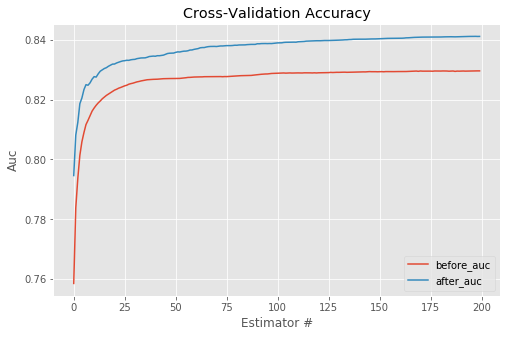

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制结果曲线

N = np.arange(200)
plt.style.use("ggplot")
plt.figure(figsize=(8, 5))
plt.plot(N, cv_res1["auc-mean"], label="before_auc")
plt.plot(N, cv_res2["auc-mean"], label="after_auc")
plt.title("Cross-Validation Accuracy")
plt.xlabel("Estimator #")
plt.ylabel("Auc")
plt.legend()
# plt.show()
plt.savefig('./cv_accuracy.pdf')
 
# plt.figure()
# plt.plot(N, cv_res1["loss"], label="before_loss")
# plt.plot(N, cv_res2["loss"], label="after_loss")
# plt.title("Cross-Validation Loss")
# plt.xlabel("Estimator #")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()
# plt.savefig('./output/simple_nn_plot_loss.png')

# 4 calculate result

In [25]:
# 恢复数据
test = read_param('test')

## 4.1 LGBM结果

In [28]:
model_lgb_v4 = gload('model_lgb_v4')

In [29]:
sub['label'] = model_lgb_v4.predict_proba(test[feature_cols])[:, 1]

In [30]:
sub['label']

0          0.320011
1          0.064840
2          0.033373
3          0.384727
4          0.015286
             ...   
1141713    0.031599
1141714    0.017698
1141715    0.060716
1141716    0.492970
1141717    0.015906
Name: label, Length: 1141718, dtype: float64

In [31]:
np.mean(sub['label'])

0.19114953123049447

In [33]:
sub.to_csv('./storage/result_v4.txt', index=None, header=None, sep='\t')

## 4.2 神经网络结果

In [37]:
res = model.predict(test[feature_cols], batch_size=BATCH_SIZE)
res

array([[0.51117074],
       [0.51117074],
       [0.51117074],
       ...,
       [0.5111708 ],
       [0.5111708 ],
       [0.5111708 ]], dtype=float32)

In [87]:
test[feature_cols]

,freq,freq_count,gender,gender_count,hour,q_ans_count,q_diff_qa_days_max,q_diff_qa_days_mean,q_diff_qa_days_sum,q_has_img_max,...,uf_c2_count,uf_c3,uf_c3_count,uf_c4,uf_c4_count,uf_c5,uf_c5_count,uid_enc,uid_enc_count,wk
0,6,0.325453,4,0.0000,9,NaN,NaN,NaN,NaN,NaN,...,0.439214,203,0.479449,1376,0.000038,3,0.346068,1752473,0.000000,6
1,2,0.726702,4,0.0000,22,NaN,NaN,NaN,NaN,NaN,...,0.439214,396,0.456703,521,0.008534,3,0.346068,767938,0.000000,1
2,6,0.325453,2,0.4874,15,NaN,NaN,NaN,NaN,NaN,...,0.439214,205,0.083870,445,0.007599,3,0.346068,1147981,0.000009,3
3,5,1.000000,3,1.0000,4,4.0,11.0,3.0,12.0,0.0,...,0.439214,188,0.114102,1038,0.001950,2,1.000000,1372679,0.000015,2
4,6,0.325453,2,0.4874,19,NaN,NaN,NaN,NaN,NaN,...,0.168475,336,0.137013,788,0.001688,3,0.346068,1,0.297591,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141678,6,0.325453,4,0.0000,20,NaN,NaN,NaN,NaN,NaN,...,0.168475,81,0.020067,760,0.434533,3,0.346068,504330,0.000000,5
1141679,3,0.118357,4,0.0000,21,NaN,NaN,NaN,NaN,NaN,...,0.439214,121,0.094249,760,0.434533,3,0.346068,1066119,0.000003,1
1141680,2,0.726702,4,0.0000,15,NaN,NaN,NaN,NaN,NaN,...,0.001308,313,0.056923,760,0.434533,3,0.346068,435862,0.000000,0
1141681,6,0.325453,4,0.0000,8,NaN,NaN,NaN,NaN,NaN,...,0.439214,8,0.442846,1375,0.031122,3,0.346068,1287652,0.000015,0
